In [2]:
import os
import operator

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from clickhouse_driver import Client

client = Client('localhost', database="thesisproxyoccupancytimeoutdb")

In [3]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)

exp_df["request_timeout"] = exp_df["request_timeout"].astype(int)

print(sorted(exp_df["request_timeout"].unique()))

print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

[5, 15, 30, 45, 60]
10
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_

exp_id  \
0  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
9  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

  attacker_rate  server_connections  max_keep_alive_requests  num_clients  \
0       100mbps                 256                        0            8   
1       100mbps                 256                        0            8   
2       100mbps                 256                        0            8   
3       100mbps                 256                        0            8   
4       100mbps                 256                        0            8   
5       100mbps                 256                        0            8   
6       100mbps                 256                        0            8   
7       100mbps                 256                        0            8   
8       100mbps                 256                        0            8   
9       100mbps                 256                        0            8   

   num_trials  origin_server_duration  attacker_duration  receiver_duration  \
0           5                     140                 30                140   
1           5                     140                 30                140   
2           5                     140                 30                140   
3           5                     140                 30                140   
4           5                     140                 30                140   
5           5                     140                 30                140   
6           5                     140                 30                140   
7           5                     140                 30                140   
8           5                     140                 30                140   
9           5                     140                 30                140   

   proxy_duration  ...                             topology_name  \
0             140  ...  thesis_cloud_proxy_and_internet_attacker   
1             140  ...  thesis_cloud_proxy_and_internet_attacker   
2             140  ...  thesis_cloud_proxy_and_internet_attacker   
3             140  ...  thesis_cloud_proxy_and_internet_attacker   
4             140  ...  thesis_cloud_proxy_and_internet_attacker   
5             140  ...  thesis_cloud_proxy_and_internet_attacker   
6             140  ...  thesis_cloud_proxy_and_internet_attacker   
7             140  ...  thesis_cloud_proxy_and_internet_attacker   
8             140  ...  thesis_cloud_proxy_and_internet_attacker   
9             140  ...  thesis_cloud_proxy_and_internet_attacker   

   num_proxy

In [4]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))
proxy_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("proxy"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))
attacker_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("attacker"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{proxy_dnids=}")
print(f"{client_node_ids=}")
print(f"{attacker_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 98, 99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117}
attacker_dnids={1, 97, 37, 73, 13, 109, 49, 85, 25, 61}
proxy_dnids={35, 71, 11, 107, 47, 83, 119, 23, 59, 95}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
attacker_node_ids={1}
CPU times: user 7.6 ms, sys: 0 ns, total: 7.6 ms
Wall time: 28.8 ms


In [5]:
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' 'bad_gateway' '']


exp_id  \
0       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                  ...   
440827  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440828  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440829  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440830  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440831  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        trial observer_id  message_marker response_code  send_time_sec  \
0           1     client1               1       content       0.000000   
1           1     client1               2       content       0.368913   
2           1     client1               3       content       0.431380   
3           1     client1               4       content       0.492094   
4           1     client1               5       content       0.551819   
...       ...         ...             ...           ...            ...   
440827      5     client8            4954       content      37.290514   
440828      5     client8            9438       content      37.491369   
440829      5     client8           29145       content      38.313905   
440830      5     client8           95827       content      41.092547   
440831      5     client8          724947                    83.921051   

        recv_time_sec  first_send_time_sec  last_send_time_sec  \
0            0.351116             0.000000            0.000000   
1            0.428905             0.368913            0.368913   
2            0.489696             0.431380            0.431380   
3            0.549362             0.492094            0.492094   
4            0.608503             0.551819            0.551819   
...               ...                  ...                 ...   
440827      37.490319            37.290514           37.290514   
440828      38.312782            37.491369           37.491369   
440829      41.091341            38.313905           40.531516   
440830      83.919629            41.092547           76.149647   
440831       0.000000            83.921051          120.448260   

        first_recv_time_sec  ...                             topology_name  \
0                  0.351116  ...  thesis_cloud_proxy_and_internet_attacker   
1                  0.428905  ...  thesis_cloud_proxy_and_internet_attacker   
2                  0.489696  ...  thesis_cloud_proxy_and_internet_attacker   
3                  0.549362  ...  thesis_cloud_proxy_and_internet_attacker   
4                  0.608503  ...  thesis_cloud_proxy_and_internet_attacker   
...                     ...  ...                                       ...   
440827            37.490319  ...  thesis_clou

In [6]:
%%time

client_sends_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
)

SELECT * FROM client_sends
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_sends_df = client.query_dataframe(client_sends_sql)
client_sends_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_sends_df

CPU times: user 1.09 s, sys: 444 ms, total: 1.53 s
Wall time: 1.91 s


exp_id  \
0       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                  ...   
443783  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
443784  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
443785  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
443786  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
443787  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        observe_timestamp  trial observer_id  message_marker  \
0                0.000000      1     client1               1   
1                0.368913      1     client1               2   
2                0.431380      1     client1               3   
3                0.492094      1     client1               4   
4                0.551819      1     client1               5   
...                   ...    ...         ...             ...   
443783         120.448260      5     client8          724947   
443784         100.967638      5     client8          724947   
443785          91.227063      5     client8          724947   
443786          83.921051      5     client8          724947   
443787          86.356539      5     client8          724947   

        coap_retransmitted  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
...                    ...  
443783                True  
443784                True  
443785                True  
443786               False  
443787                True  

[443788 rows x 6 columns]

In [7]:
%%time

client_recvs_sql = f"""
WITH client_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT * FROM client_recvs
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_recvs_df = client.query_dataframe(client_recvs_sql)
client_recvs_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_recvs_df["successful_message"] = False
client_recvs_df.loc[(client_recvs_df["response_code"] == "content"), "successful_message"] = True

print(client_recvs_df["response_code"].unique())

client_recvs_df

['content' 'bad_gateway']
CPU times: user 1.16 s, sys: 174 ms, total: 1.33 s
Wall time: 1.83 s


exp_id  \
0       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                  ...   
440436  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440437  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440438  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440439  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440440  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        observe_timestamp  trial observer_id  message_marker response_code  \
0                0.351116      1     client1               1       content   
1                0.428905      1     client1               2       content   
2                0.489696      1     client1               3       content   
3                0.549362      1     client1               4       content   
4                0.608503      1     client1               5       content   
...                   ...    ...         ...             ...           ...   
440436          37.289497      5     client8            4946       content   
440437          37.490319      5     client8            4954       content   
440438          38.312782      5     client8            9438       content   
440439          41.091341      5     client8           29145       content   
440440          83.919629      5     client8           95827       content   

        successful_message  
0                     True  
1                     True  
2                     True  
3                     True  
4                     True  
...                    ...  
440436                True  
440437                True  
440438                True  
440439                True  
440440                True  

[440441 rows x 7 columns]

In [8]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 34.2 ms, sys: 723 µs, total: 35 ms
Wall time: 99.7 ms


exp_id  \
0    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                ...   
195  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
196  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
197  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
198  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
199  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial   observer_id         metric_type    avg_value  min_value  \
0        1  originserver     cpu_utilization     6.491429        0.4   
1        1         proxy     cpu_utilization    17.980714        0.5   
2        1  originserver  memory_utilization   267.271523      242.0   
3        1         proxy  memory_utilization  3619.836394      248.0   
4        2  originserver     cpu_utilization     6.098571        0.5   
..     ...           ...                 ...          ...        ...   
195      4         proxy  memory_utilization  3628.232441      252.0   
196      5  originserver     cpu_utilization    13.940714        0.4   
197      5         proxy     cpu_utilization    24.487857        0.4   
198      5  originserver  memory_utilization   285.458472      256.0   
199      5         proxy  memory_utilization  3651.702838      253.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         23.7       100mbps                 256                        0   
1         84.2       100mbps                 256                        0   
2        298.0       100mbps                 256                        0   
3       6077.0       100mbps                 256                        0   
4         22.1       100mbps                 256                        0   
..         ...           ...                 ...                      ...   
195     6385.0       100mbps                 256                        0   
196       26.7       100mbps                 256                        0   
197       85.7       100mbps                 256                        0   
198      335.0       100mbps                 256                        0   
199     6365.0       100mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     50   
3    ...  thesis_cloud_proxy_and_internet_attacker                     50   
4    ...  thesis_cloud_proxy_and_internet_attacker                     50   
..   ...                                       ...    

In [9]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 3.42 s, sys: 37.9 ms, total: 3.45 s
Wall time: 3.7 s


exp_id  \
0    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                ...   
395  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
396  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
397  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
398  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
399  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  num_messages  num_successful_messages   mean_rps  \
0        1     client1          1383                     1381  11.508333   
1        1     client2          1392                     1389  11.575000   
2        1     client3          1386                     1383  11.525000   
3        1     client4          1393                     1390  11.583333   
4        1     client5          1394                     1392  11.600000   
..     ...         ...           ...                      ...        ...   
395      5     client4           635                      634   5.283333   
396      5     client5           616                      615   5.125000   
397      5     client6           597                      596   4.966667   
398      5     client7           577                      576   4.800000   
399      5     client8           560                      559   4.658333   

     max_num_retransmissions  total_num_retransmissions  stddev_rtt_ms  \
0                          2                          6     690.910393   
1                          2                          7     644.054828   
2                          2                          7     655.071446   
3                          2                          7     653.720650   
4                          2                          7     635.033207   
..                       ...                        ...            ...   
395                        4                          8     876.014921   
396                        4                          7    1205.288286   
397                        3                          8    1581.210999   
398                        4                          7    1585.711538   
399                        4                          9    1812.840439   

     min_rtt_ms  ...                             topology_name  \
0     51.512957  ...  thesis_cloud_proxy_and_internet_attacker   
1     51.547050  ...  thesis_cloud_proxy_and_internet_attacker   
2     51.543951  ...  thesis_cloud_proxy_and_internet_attacker   
3     51.447868  ...  thesis_cloud_proxy_and_internet_attacker   
4     51.489115  ...  thesis_cloud_proxy_and_internet_attacker   
..          ...  ...                                       ...   
395   52.173138  ...  thesis_cloud_proxy_a

In [26]:
### Prepare for dev graphing.

import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)

In [46]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

value_map_replacement = {
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    False: "CoAP",
    "dtls": "CoAPS",
    True: "CoAPS",
  },
  "reuse_connections": {
    "reuse-connections": "Reuse Connections",
    True: "Reuse Connections",
    "no-connection-reuse": "No Connection Reuse",
    False: "No Connection Reuse",
  },
  "run_attacker": {
    "attacker": "With Attacker",
    True: "With Attacker",
    "no-attacker": "Without Attacker",
    False: "Without Attacker",
  },
  "response_code": {
    "bad_gateway": "Bad Gateway",
    "content": "Content",
  },
}

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)

metric_df.replace({
  "run_proxy_with_dtls": {
    False: "CoAP",
    True : "CoAPS",
  }
}, inplace=True)

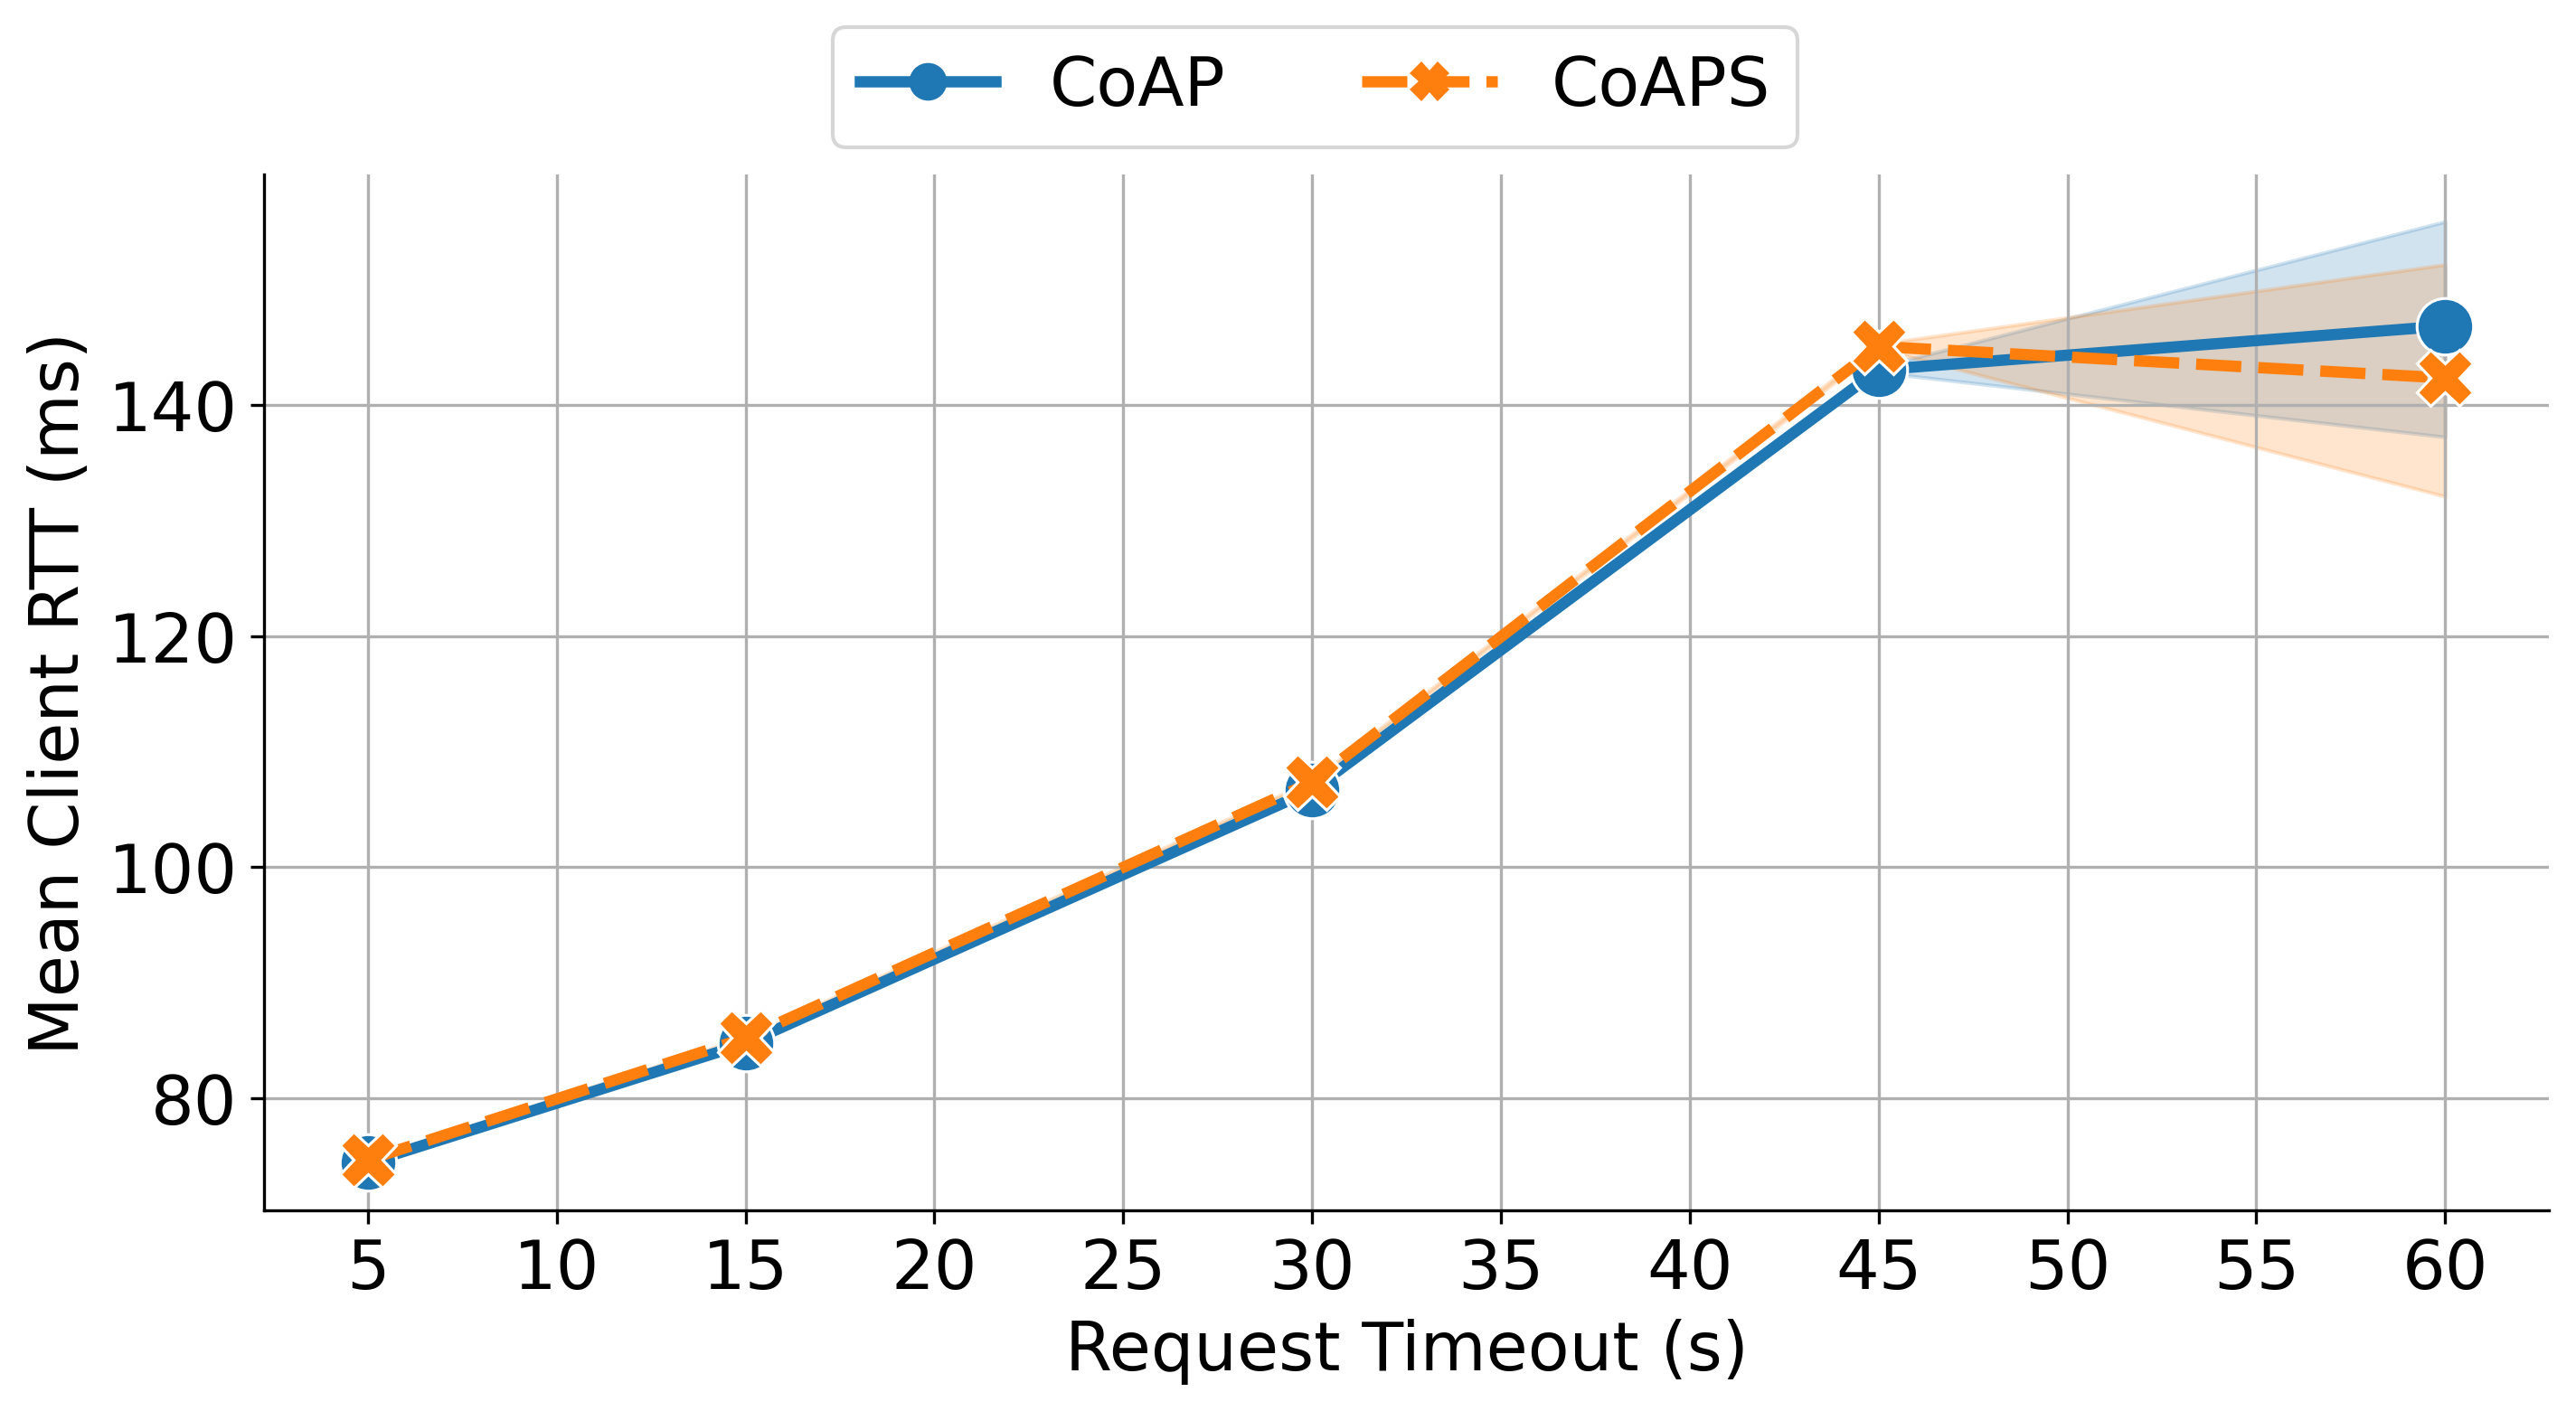

CPU times: user 1.28 s, sys: 168 ms, total: 1.45 s
Wall time: 1.14 s


mean_rtt_ms
request_timeout run_proxy_with_dtls             
5               CoAP                   74.401741
                CoAPS                  74.654058
15              CoAP                   84.728212
                CoAPS                  85.204544
30              CoAP                  106.661046
                CoAPS                 107.356715
45              CoAP                  143.047242
                CoAPS                 145.067805
60              CoAP                  146.833690
                CoAPS                 142.336822

In [34]:
%%time

### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df

g = sns.relplot(
  data=df,
  kind="line",
  x="request_timeout",
  y="mean_rtt_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  aspect=2,
)

g.legend.set_title("Client Protocol")
g.set_xlabels("Request Timeout (s)")
g.set_ylabels("Mean Client RTT (ms)")
g.set(xticks=np.arange(5,61,5))

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.42, 1.08),
  ncol=2,
  title=None,
  frameon=True,
)

plt.grid(True, axis="both")
plt.show()

(
  df.groupby(
    by=["request_timeout", "run_proxy_with_dtls"]
  )
  .agg(
    mean_rtt_ms=("mean_rtt_ms", "mean")
  )
)

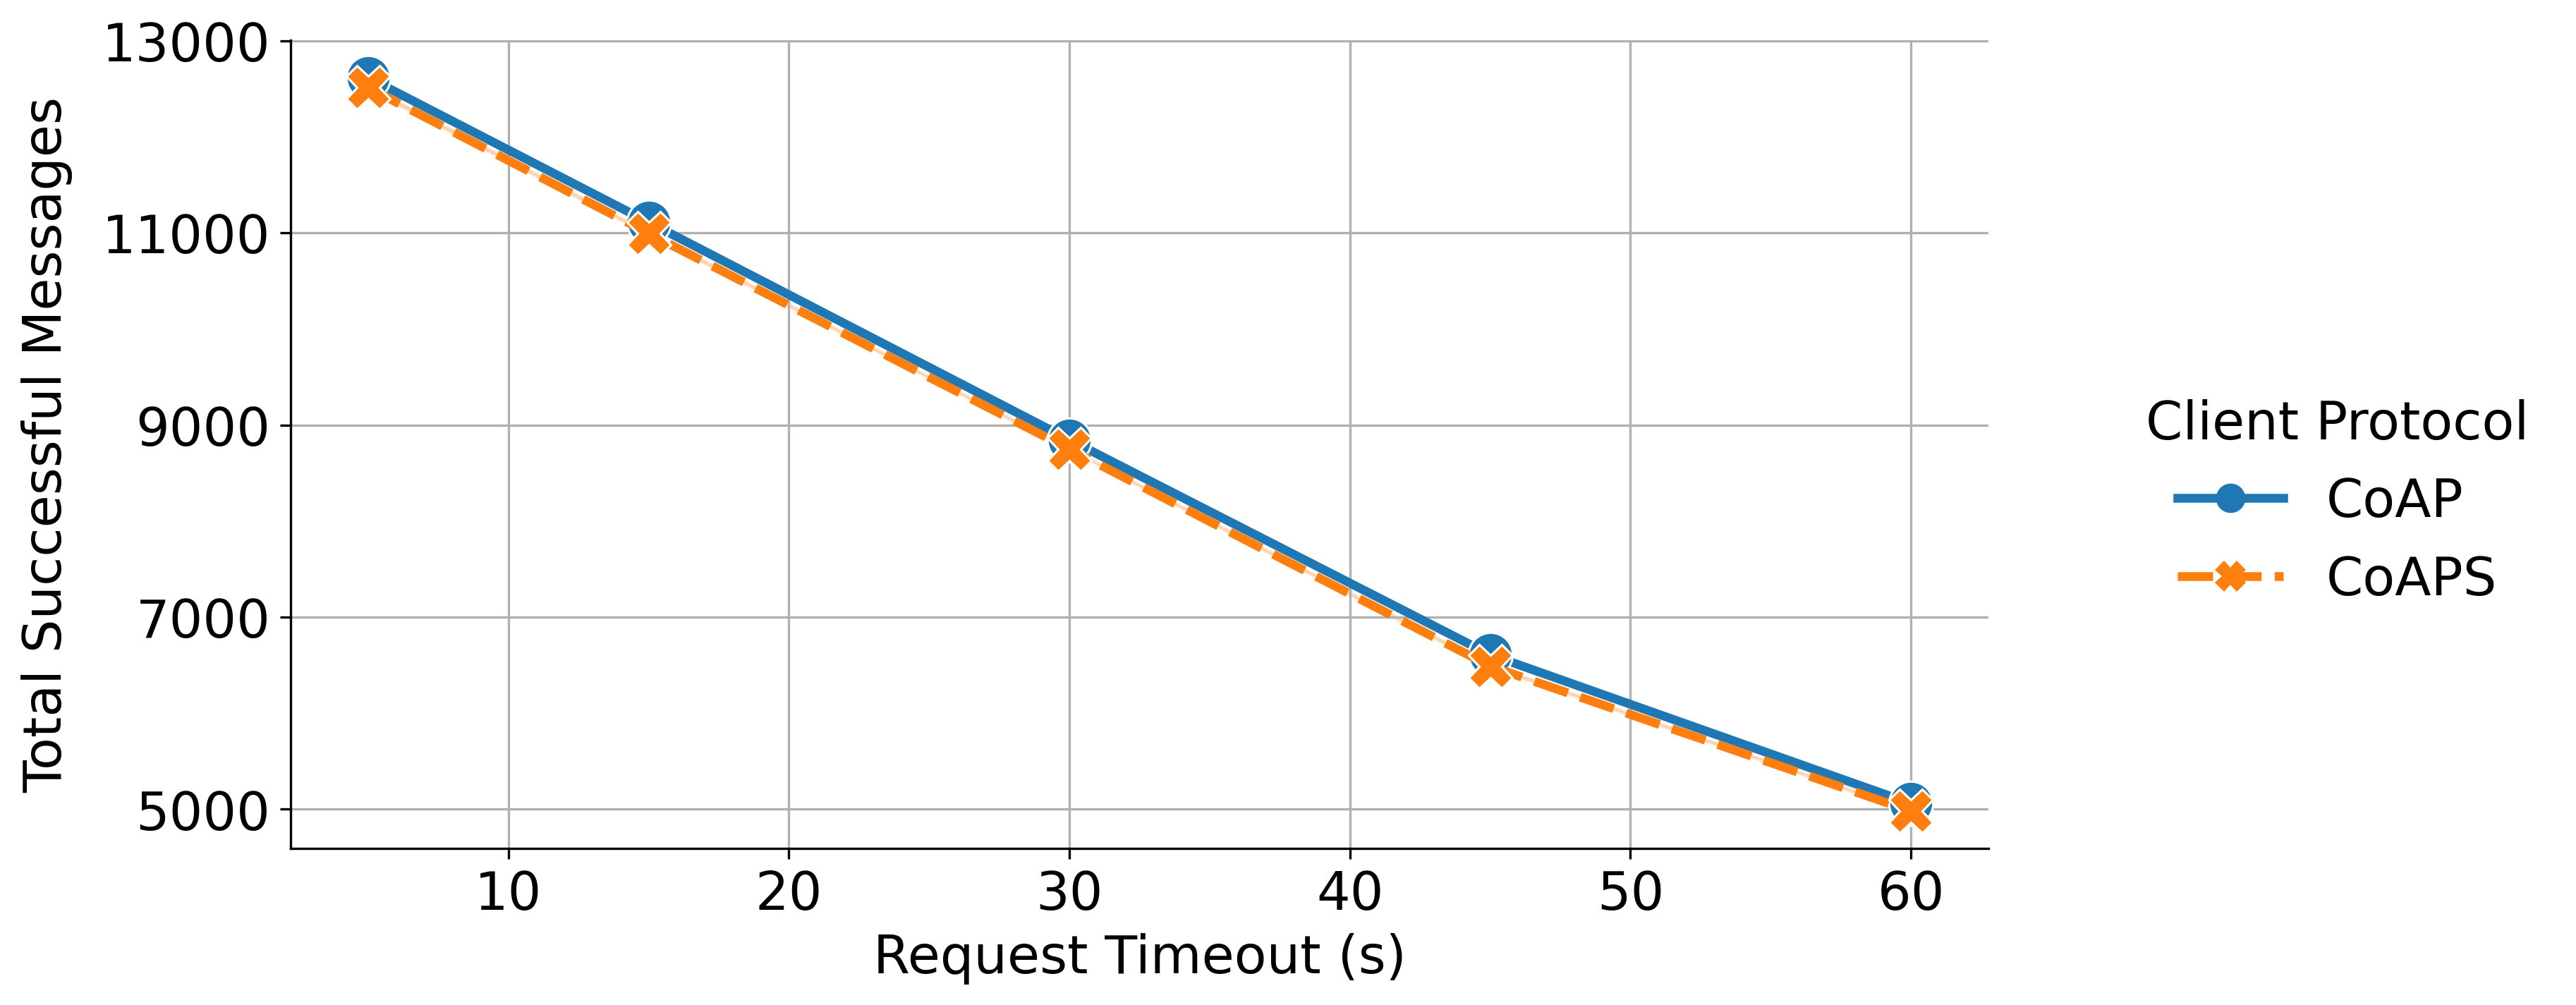

exp_id  \
0   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
9   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
12  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
14  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
15  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
17  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
18  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
19  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
20  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
21  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
22  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
23  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
24  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
25  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
26  thesis_group_proxy_occ_timeout_8cl

In [55]:
## Plot total number of successful messages.

client_rps_df["active_time_sec"] = client_rps_df["last_active_time"] - client_rps_df["first_active_time"]

df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "request_timeout", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
    mean_active_time_sec=("active_time_sec", "mean"),
  )
  .reset_index()
)
df["amortized_successful_rps"] = df["total_successful_messages"] / df["mean_active_time_sec"] / df["num_clients"]

g = sns.relplot(
  data=df,
  kind="line",
  x="request_timeout",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  aspect=2,
)

g.set(
  yticks=np.arange(5_000,15_000,2_000),
)

g.set_xlabels("Request Timeout (s)")
g.set_ylabels("Total Successful Messages", labelpad=10)
g.legend.set_title("Client Protocol")

plt.grid(True, axis="both")
plt.show()

df

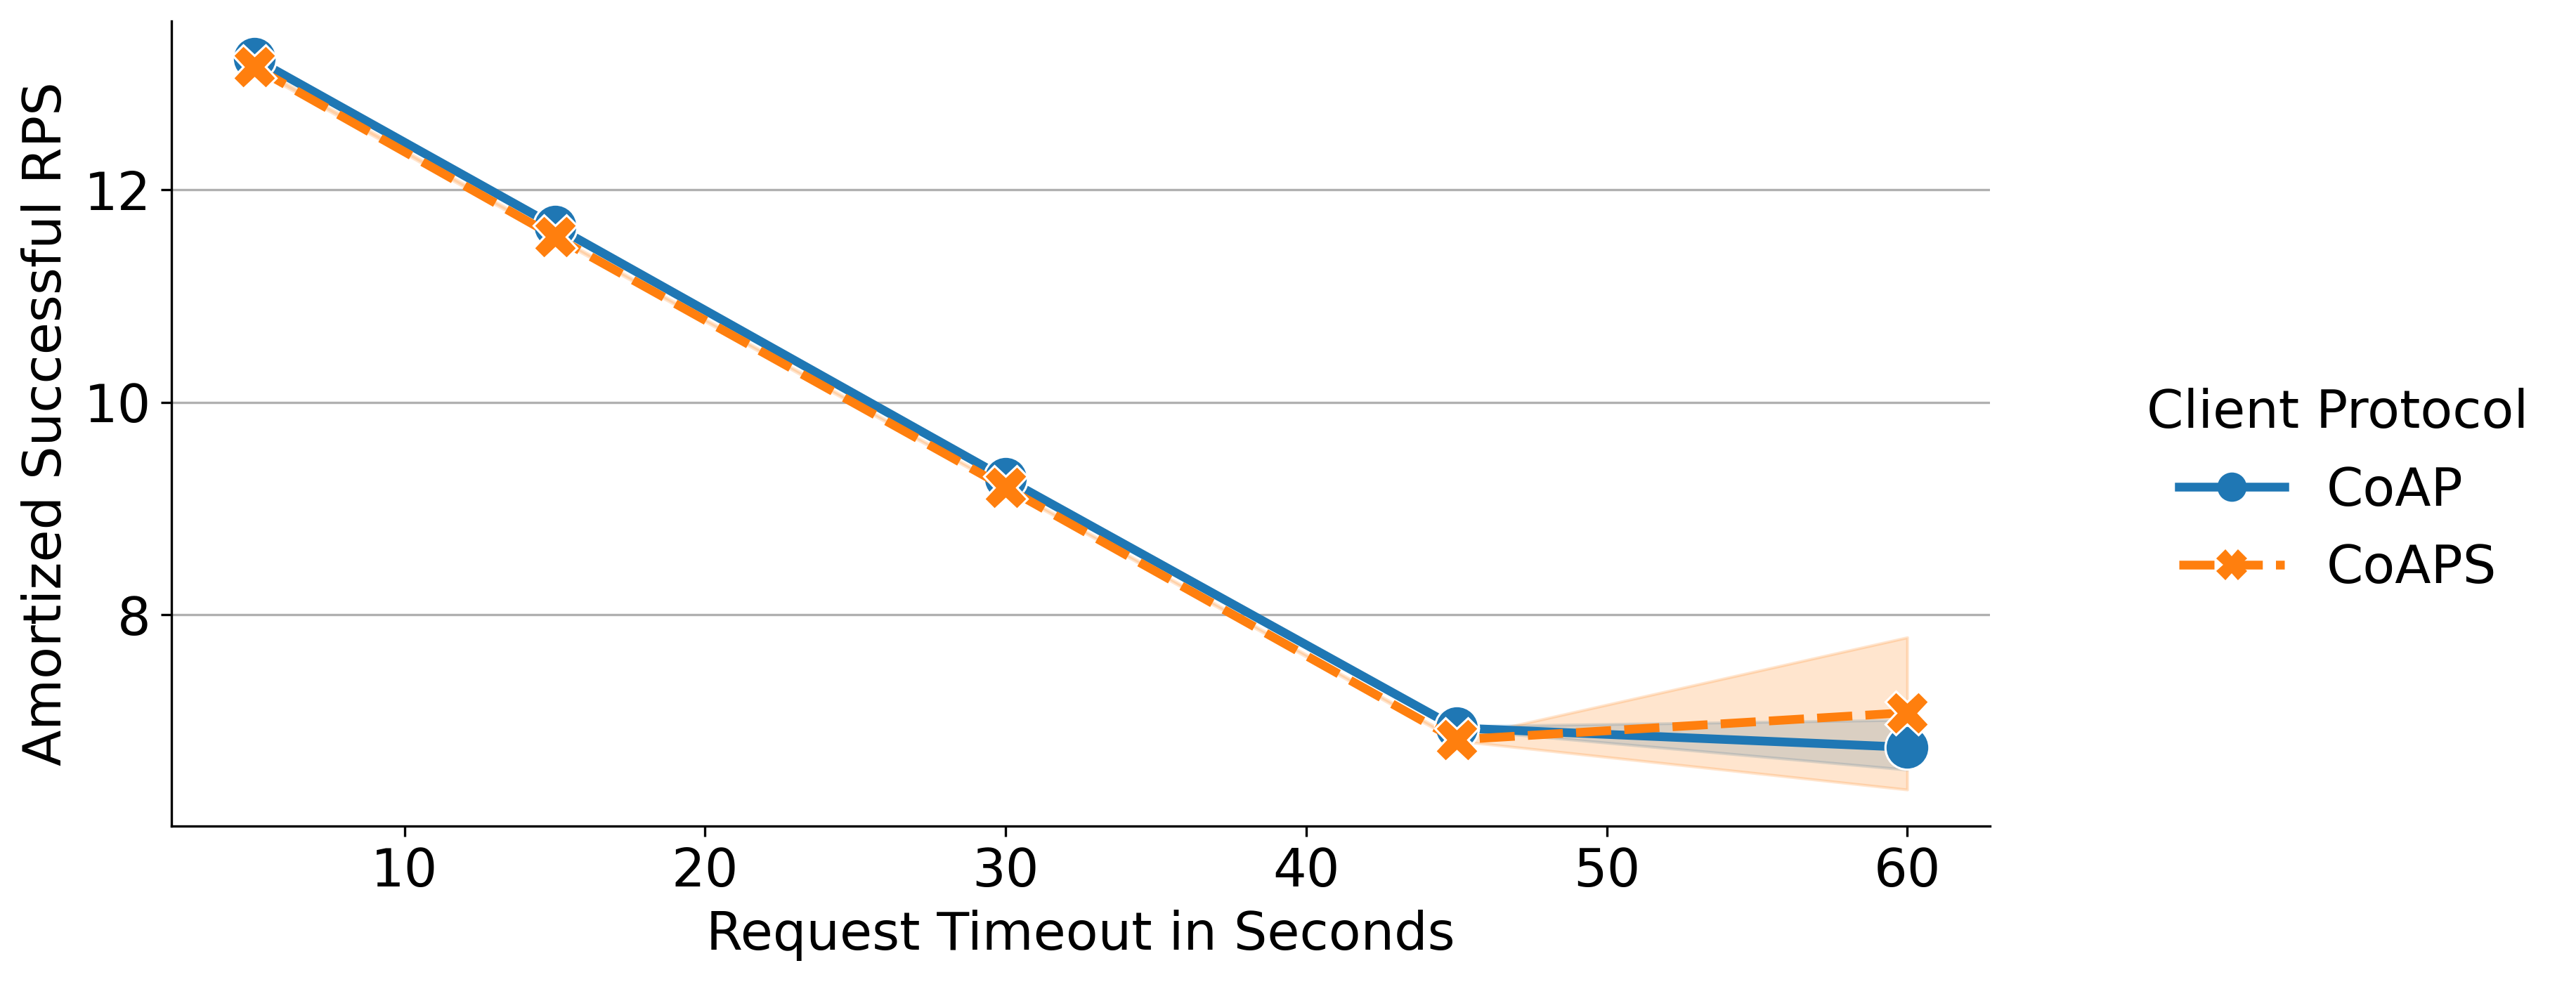

exp_id  \
0   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
9   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
12  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
14  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
15  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
17  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
18  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
19  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
20  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
21  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
22  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
23  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
24  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
25  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
26  thesis_group_proxy_occ_timeout_8cl

In [14]:
g = sns.relplot(
  data=df,
  kind="line",
  x="request_timeout",
  y="amortized_successful_rps",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  aspect=2,
  markers=True,
  markersize=15,
)

g.set_xlabels("Request Timeout in Seconds")
g.set_ylabels("Amortized Successful RPS")
g.legend.set_title("Client Protocol")
# g.refline(
#   y=100.0,
#   color="black",
#   linestyle="solid",
#   linewidth=0.05,
# )

plt.grid(True, axis="y")
plt.show()

df

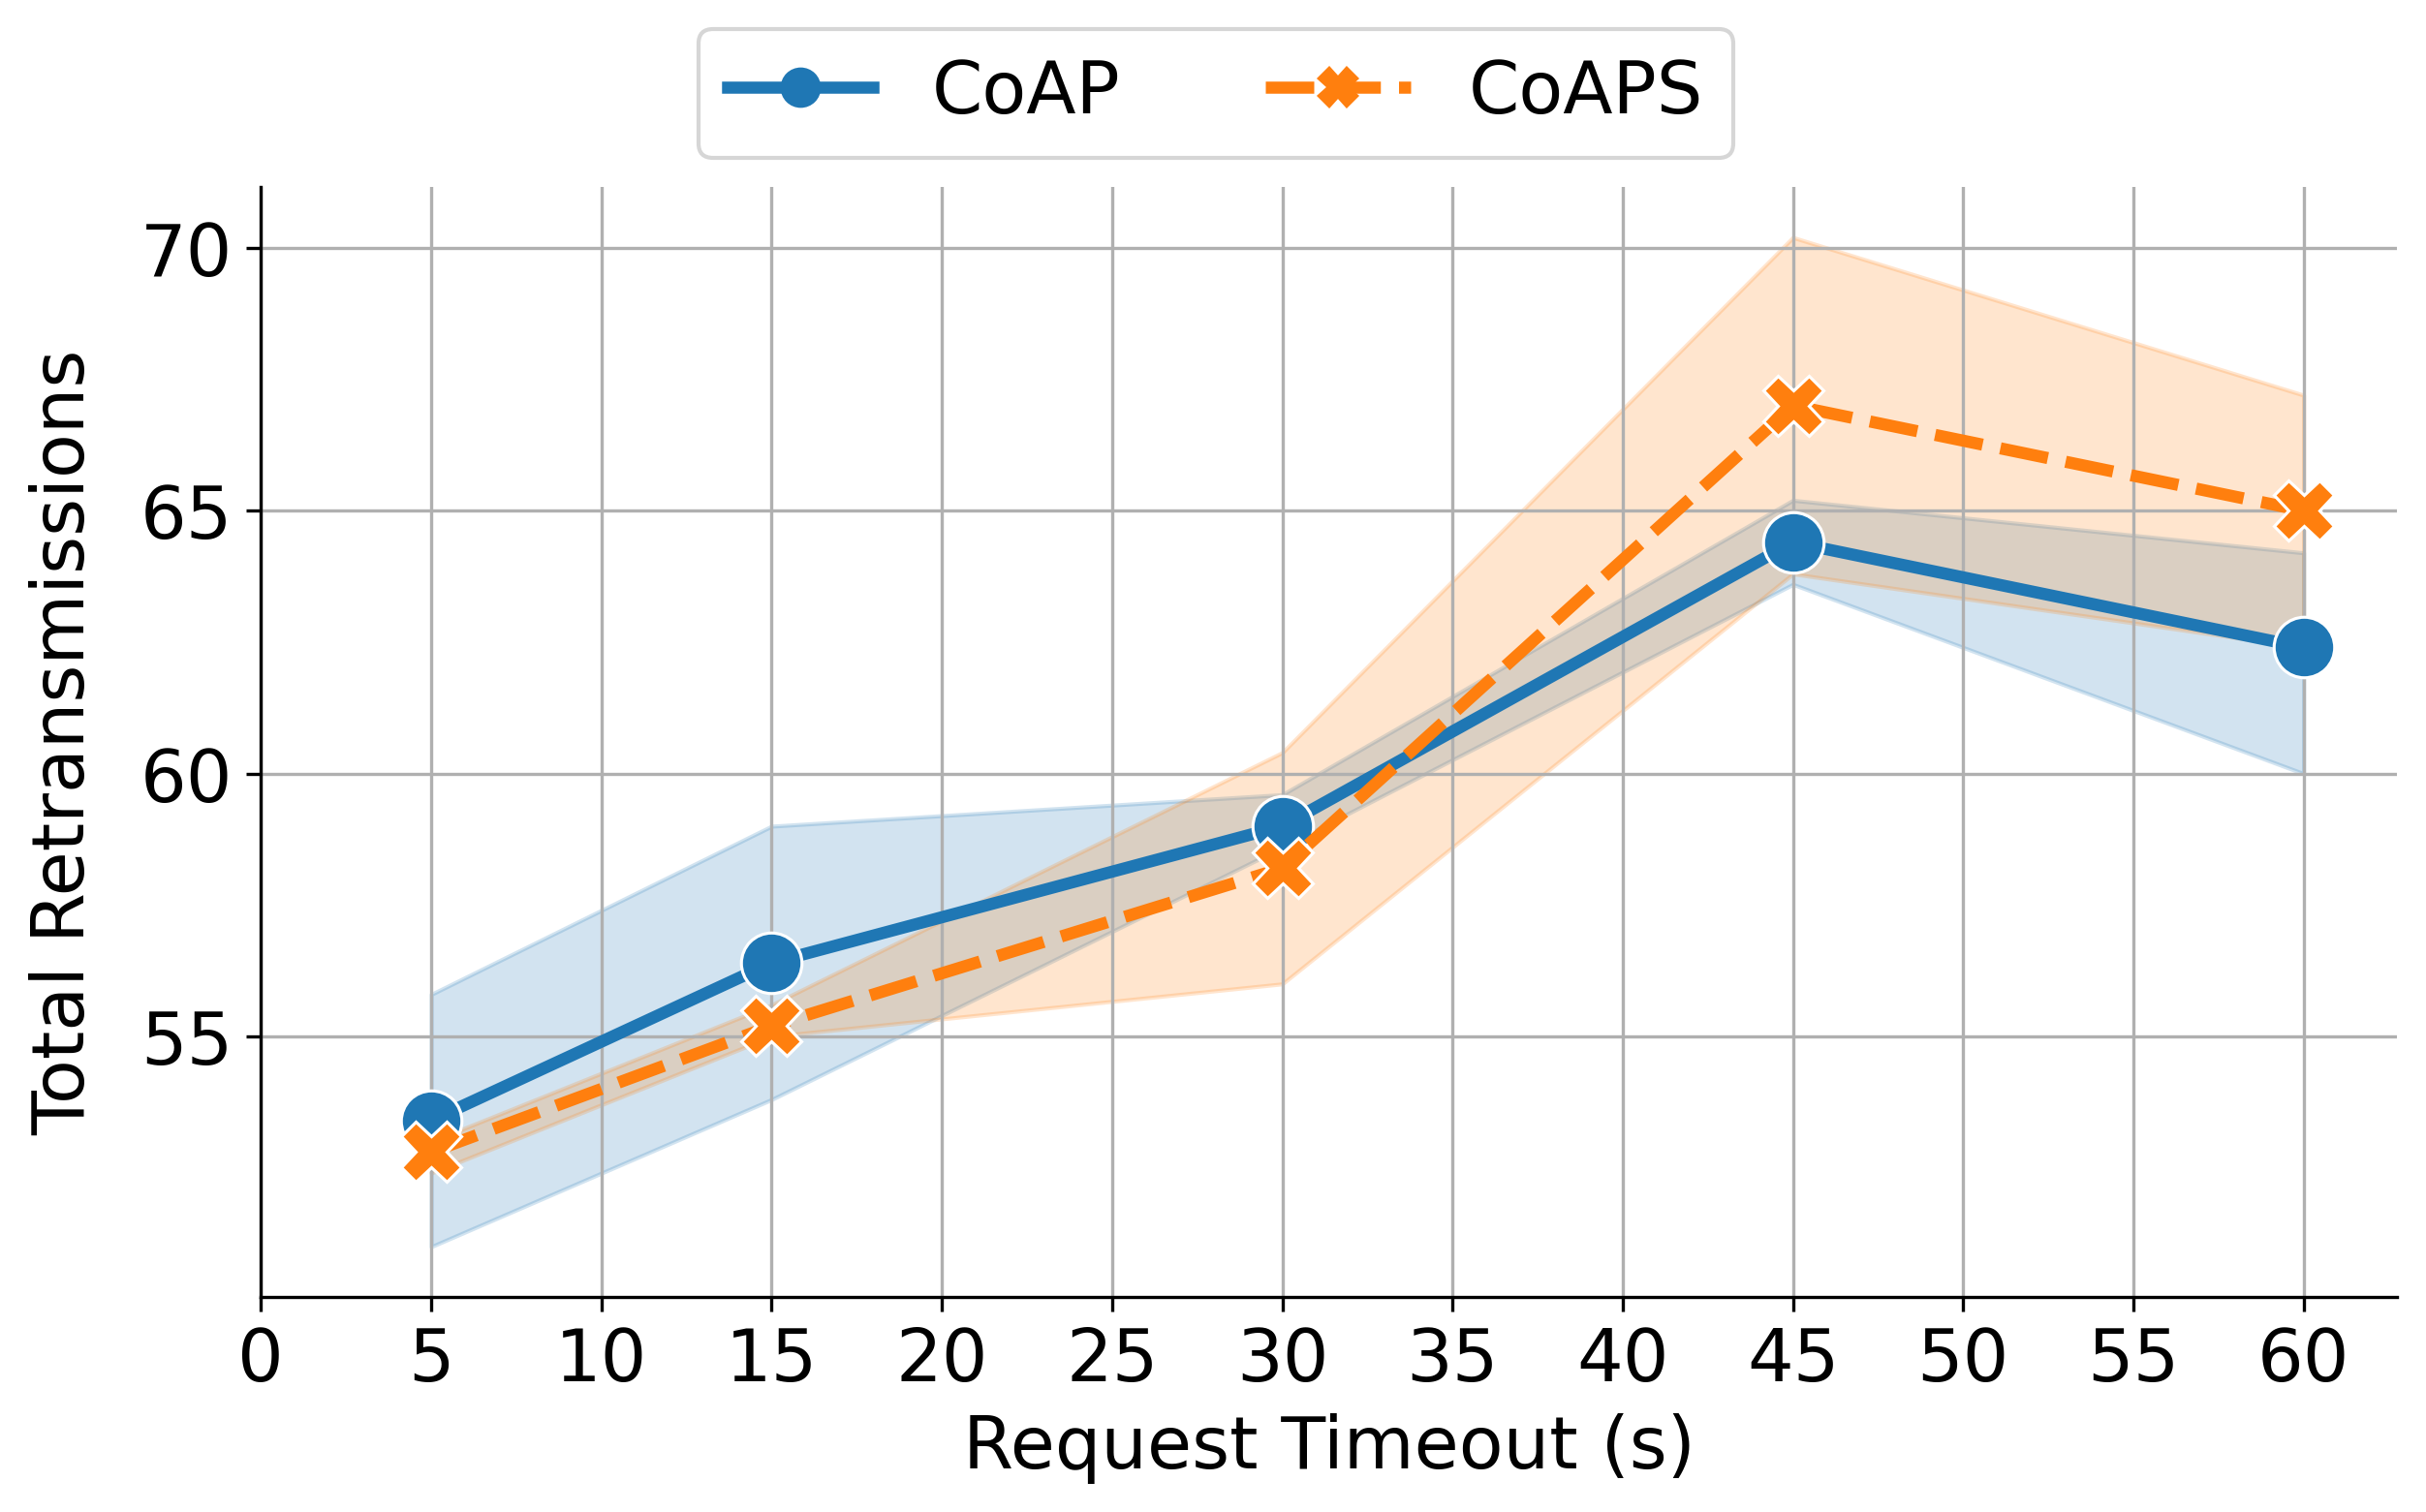

exp_id  \
0   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
9   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
12  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
14  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
15  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
17  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
18  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
19  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
20  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
21  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
22  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
23  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
24  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
25  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
26  thesis_group_proxy_occ_timeout_8cl

In [77]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "num_clients", "request_timeout", "run_proxy_with_dtls"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)

g = sns.relplot(
  data=df,
  kind="line",
  x="request_timeout",
  y="total_num_retransmissions",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  aspect=1.75,
)

g.set_xlabels("Request Timeout (s)")
g.set_ylabels("Total Retransmissions", labelpad=10)
g.set(xticks=np.arange(0,61,5))
g.legend.set_title("Client Protocol")

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.4, 1.08),
  ncol=2,
  title=None,
  frameon=True,
)

plt.grid(True, axis="both")
plt.show()

df[df["total_num_retransmissions"] > 0]

In [16]:
%%time

## Determine transaction success rate

# Combine send and receive events for clients.
client_events_df = client_sends_df.merge(client_recvs_df, on=["exp_id", "trial", "observer_id", "message_marker"], how="left")
client_events_df.rename(columns={
  "observe_timestamp_x": "send_timestamp",
  "observe_timestamp_y": "recv_timestamp",
}, inplace=True)
client_events_df["rtt_ms"] = 1e3 * (client_events_df["recv_timestamp"] - client_events_df["send_timestamp"])

# Edge case: sometimes clients will not receive a
# response back at the end of the experiment, so
# we ignore those messages, if any.
grouped_last_nan_indicies_to_remove = (
  client_events_df.reset_index()[
    client_events_df["recv_timestamp"].isna()
  ]
  .groupby(by=["exp_id", "trial", "observer_id", "message_marker"])
  .agg(
    last_nan_recv_timestamp=("recv_timestamp", "last"),
    original_index=("index", "last"),
  )
  .reset_index()
  ["original_index"]
  .unique()
)
client_events_df.drop(index=grouped_last_nan_indicies_to_remove, inplace=True)
client_events_df.reset_index(inplace=True)
client_events_df.drop(columns=["index"], inplace=True)

# Produce the total number of messages, and number 
# messages with a matching successful response.
grouped_client_events_df = (
  client_events_df
  .groupby(["exp_id", "trial", "observer_id"])
  .agg(
    unique_message_markers=("message_marker", "nunique"),
    num_successful_messages=("successful_message", "sum"),
  )
  .reset_index()
)

# Now compute the successful transaction rate.
grouped_client_events_df["transaction_success_rate"] = 100 * grouped_client_events_df["num_successful_messages"] / grouped_client_events_df["unique_message_markers"]

grouped_client_events_df = (
  grouped_client_events_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

grouped_client_events_df

CPU times: user 2.03 s, sys: 143 ms, total: 2.17 s
Wall time: 2.17 s


exp_id  \
0    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                ...   
395  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
396  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
397  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
398  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
399  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
0        1     client1                    1382                    1385   
1        1     client2                    1391                    1392   
2        1     client3                    1385                    1386   
3        1     client4                    1392                    1393   
4        1     client5                    1393                    1397   
..     ...         ...                     ...                     ...   
395      5     client4                     635                     638   
396      5     client5                     616                     618   
397      5     client6                     597                     601   
398      5     client7                     577                     579   
399      5     client8                     560                     564   

    transaction_success_rate attacker_rate  server_connections  \
0                 100.217077       100mbps                 256   
1                 100.071891       100mbps                 256   
2                 100.072202       100mbps                 256   
3                 100.071839       100mbps                 256   
4                  100.28715       100mbps                 256   
..                       ...           ...                 ...   
395               100.472441       100mbps                 256   
396               100.324675       100mbps                 256   
397               100.670017       100mbps                 256   
398                100.34662       100mbps                 256   
399               100.714286       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  \
0                          0            8  ...   
1                          0            8  ...   
2                          0            8  ...   
3                          0            8  ...   
4                          0            8  ...   
..                       ...          ...  ...   
395                        0            8  ...   
396                        0            8  ...   
397                        0            8  ...   
398                        0            8  ...   
399                        0            8  ...   

                       

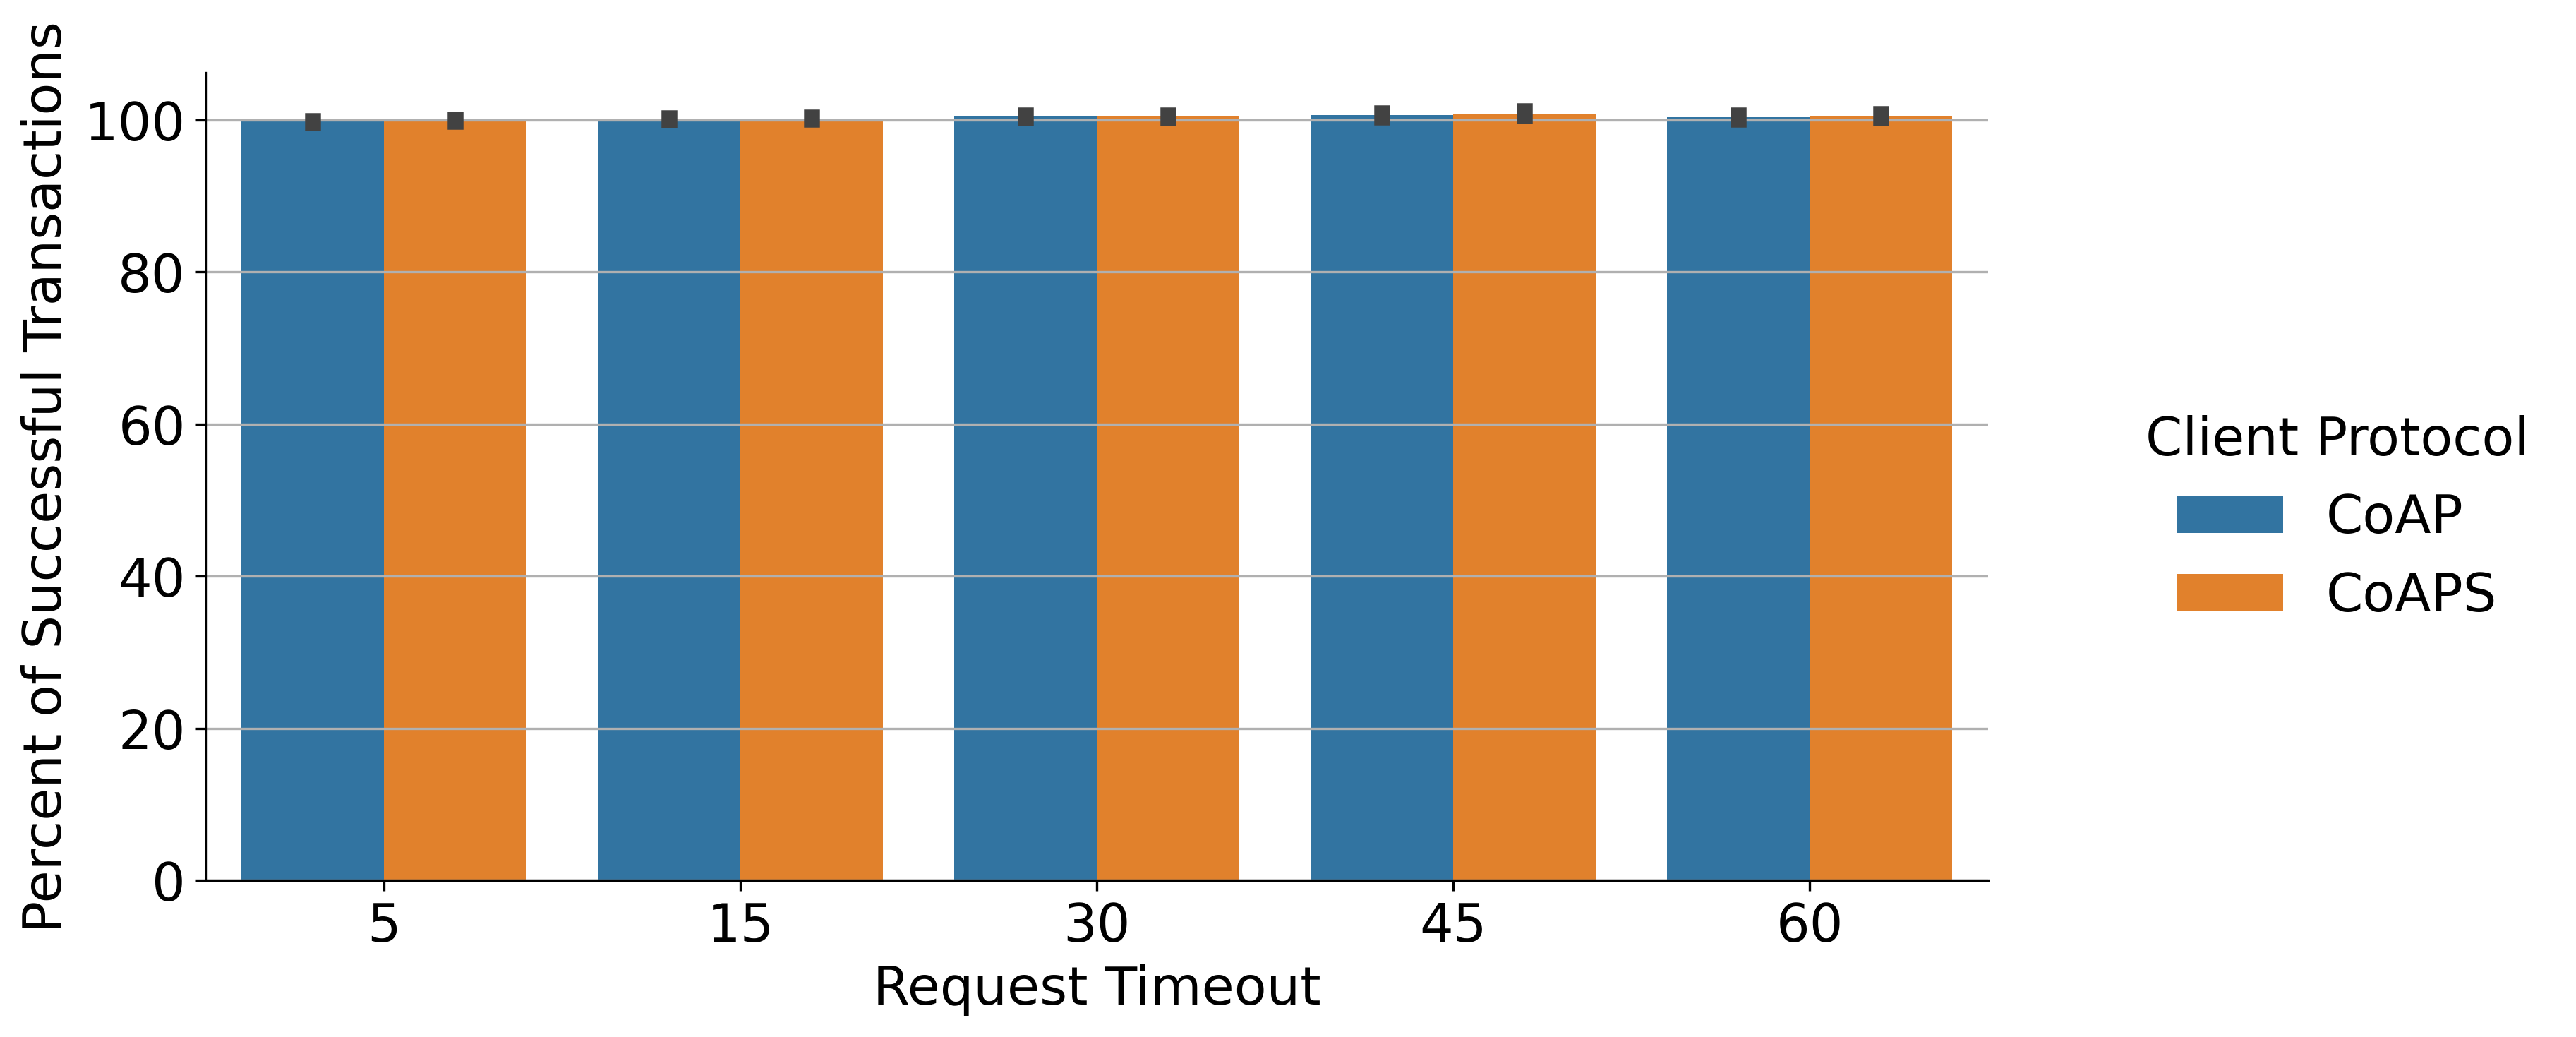

exp_id  \
14   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
20   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
65   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
77   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
240   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                ...   
312   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
313   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
314   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
318   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
319   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
14       2     client7                    1393                    1392   
20       3     client5                    1392                    1391   
65       4     client2                    1372                    1371   
77       5     client6                    1377                    1376   
240      1     client1                    1568                    1567   
..     ...         ...                     ...                     ...   
312      5     client1                    1563                    1558   
313      5     client2                    1571                    1567   
314      5     client3                    1567                    1563   
318      5     client7                    1574                    1570   
319      5     client8                    1577                    1574   

    transaction_success_rate attacker_rate  server_connections  \
14                 99.928212       100mbps                 256   
20                 99.928161       100mbps                 256   
65                 99.927114       100mbps                 256   
77                 99.927378       100mbps                 256   
240                99.936224       100mbps                 256   
..                       ...           ...                 ...   
312                99.680102       100mbps                 256   
313                99.745385       100mbps                 256   
314                99.744735       100mbps                 256   
318                 99.74587       100mbps                 256   
319                99.809765       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  \
14                         0            8  ...   
20                         0            8  ...   
65                         0            8  ...   
77                         0            8  ...   
240                        0            8  ...   
..                       ...          ...  ...   
312                        0            8  ...   
313                        0            8  ...   
314                        0            8  ...   
318                        0            8  ...   
319                        0            8  ...   

                       

In [17]:
df = grouped_client_events_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="request_timeout",
  y="transaction_success_rate",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

g.set_xlabels("Request Timeout")
g.set_ylabels("Percent of Successful Transactions")
g.legend.set_title("Client Protocol")
# g.refline(
#   y=100.0,
#   color="black",
#   linestyle="solid",
#   linewidth=0.05,
# )

plt.grid(True, axis="y")
plt.show()

grouped_client_events_df[
  grouped_client_events_df["transaction_success_rate"] < 100
]

In [18]:
# _df = client_events_df
# tdf = _df[
#   (_df["exp_id"] == "thesis_group_num_clients_dtls_https_7clients_noattacker__140sec_proxy__30sec_attacker__120sec_client")
#   & (_df["trial"] == 5)
#   & (_df["observer_id"] == "client3")
# ].reset_index().drop(columns=["index"])
# tdf[
#   tdf["response_code"] != "content"
# ]

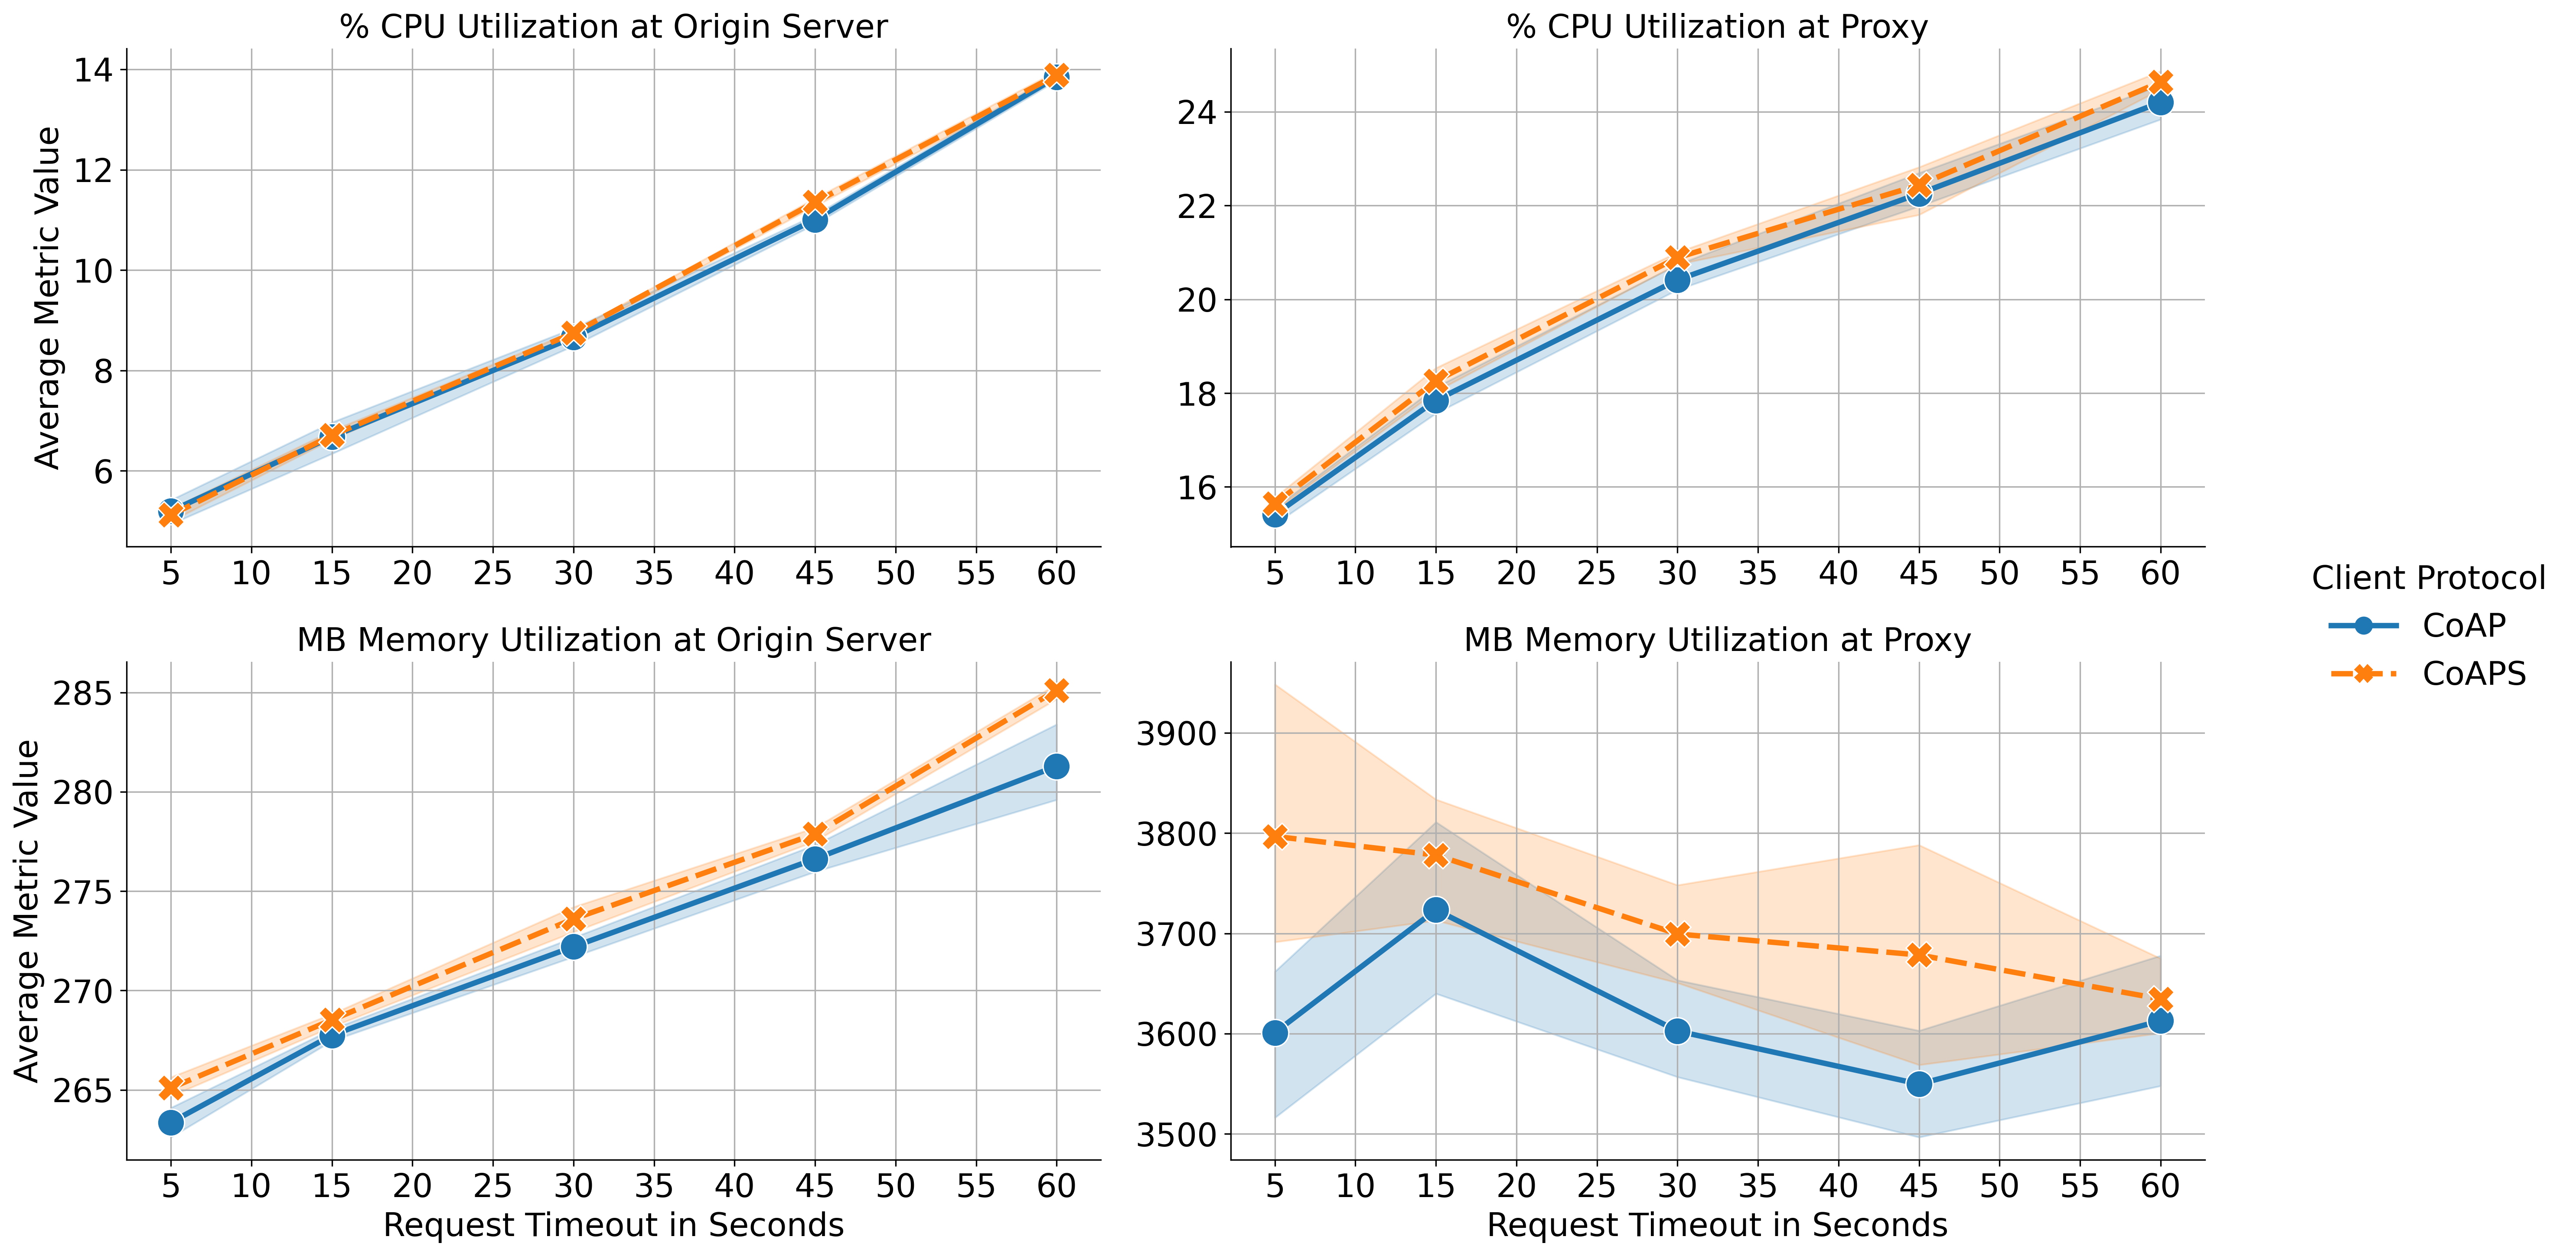

CPU times: user 4.1 s, sys: 454 ms, total: 4.55 s
Wall time: 4.21 s


exp_id  \
0    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                ...   
195  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
196  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
197  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
198  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
199  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
0        1  Origin Server      % CPU Utilization     6.491429        0.4   
1        1          Proxy      % CPU Utilization    17.980714        0.5   
2        1  Origin Server  MB Memory Utilization   267.271523      242.0   
3        1          Proxy  MB Memory Utilization  3619.836394      248.0   
4        2  Origin Server      % CPU Utilization     6.098571        0.5   
..     ...            ...                    ...          ...        ...   
195      4          Proxy  MB Memory Utilization  3628.232441      252.0   
196      5  Origin Server      % CPU Utilization    13.940714        0.4   
197      5          Proxy      % CPU Utilization    24.487857        0.4   
198      5  Origin Server  MB Memory Utilization   285.458472      256.0   
199      5          Proxy  MB Memory Utilization  3651.702838      253.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         23.7       100mbps                 256                        0   
1         84.2       100mbps                 256                        0   
2        298.0       100mbps                 256                        0   
3       6077.0       100mbps                 256                        0   
4         22.1       100mbps                 256                        0   
..         ...           ...                 ...                      ...   
195     6385.0       100mbps                 256                        0   
196       26.7       100mbps                 256                        0   
197       85.7       100mbps                 256                        0   
198      335.0       100mbps                 256                        0   
199     6365.0       100mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
0    ...  thesis_cloud_proxy_and_internet_attacker                     50   
1    ...  thesis_cloud_proxy_and_internet_attacker                     50   
2    ...  thesis_cloud_proxy_and_internet_attacker                     50   
3    ...  thesis_cloud_proxy_and_internet_attacker                     50   
4    ...  thesis_cloud_proxy_and_internet_attacker                     50   
..   .

In [19]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="request_timeout",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
  aspect=1.75,
)

g.set_titles(
  template="{row_name} at {col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Request Timeout in Seconds")
g.set_ylabels("Average Metric Value")
g.legend.set_title("Client Protocol")
# g.set(xticks=np.arange(1,9,1))

axes = [
  g.axes[0,0],
  g.axes[0,1],
  g.axes[1,0],
  g.axes[1,1],
]
for ax in axes:
  ax.set_xticks(np.arange(5,61,5))
  ax.grid(True, axis="both")

plt.show()

df

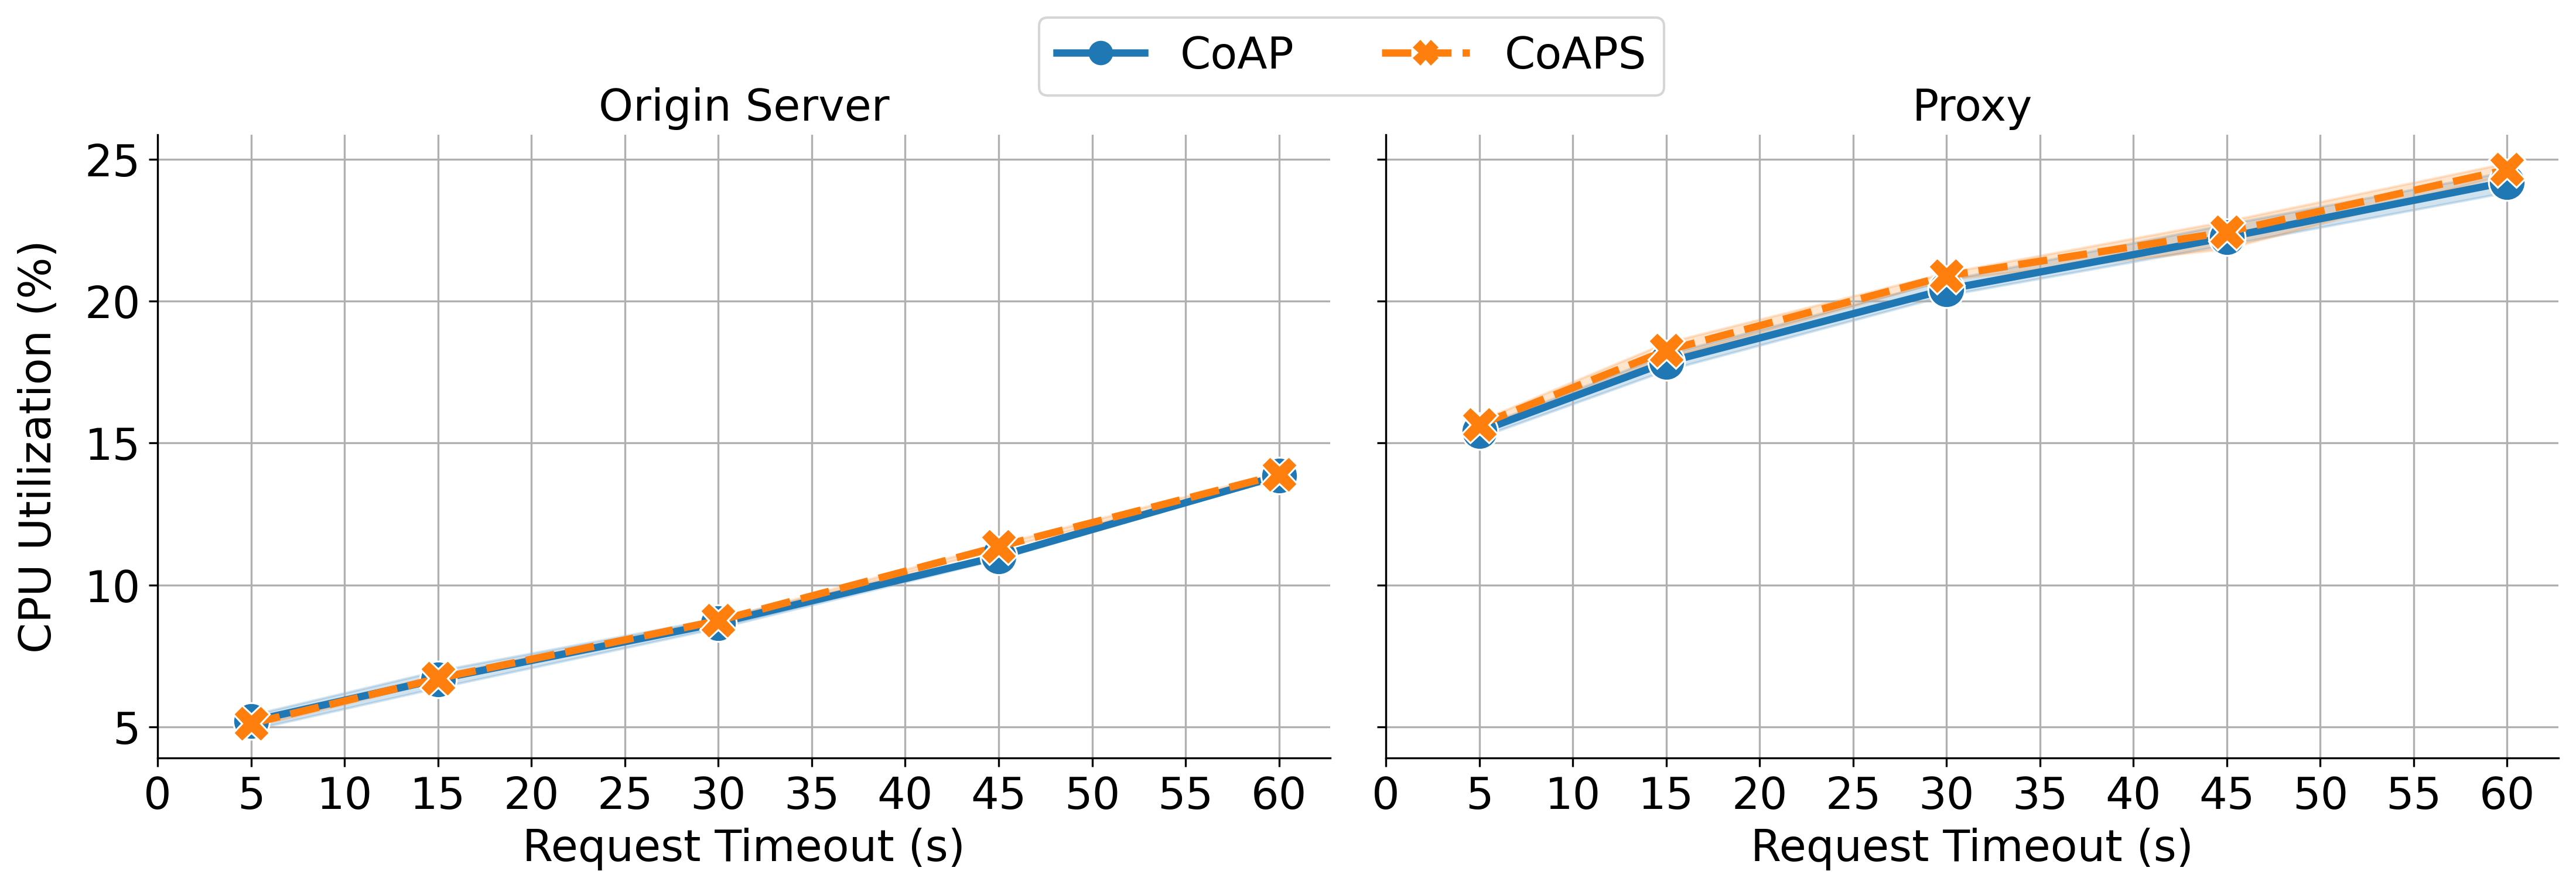

CPU times: user 2.1 s, sys: 139 ms, total: 2.24 s
Wall time: 1.94 s


exp_id  \
0    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
8    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                ...   
189  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
192  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
193  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
196  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
197  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id        metric_type  avg_value  min_value  max_value  \
0        1  Origin Server  % CPU Utilization   6.491429        0.4       23.7   
1        1          Proxy  % CPU Utilization  17.980714        0.5       84.2   
4        2  Origin Server  % CPU Utilization   6.098571        0.5       22.1   
5        2          Proxy  % CPU Utilization  18.272143        0.4       82.6   
8        3  Origin Server  % CPU Utilization   6.916429        0.3       24.3   
..     ...            ...                ...        ...        ...        ...   
189      3          Proxy  % CPU Utilization  24.499286        0.4       90.0   
192      4  Origin Server  % CPU Utilization  13.787857        0.5       28.8   
193      4          Proxy  % CPU Utilization  24.668571        0.5       89.4   
196      5  Origin Server  % CPU Utilization  13.940714        0.4       26.7   
197      5          Proxy  % CPU Utilization  24.487857        0.4       85.7   

    attacker_rate  server_connections  max_keep_alive_requests  ...  \
0         100mbps                 256                        0  ...   
1         100mbps                 256                        0  ...   
4         100mbps                 256                        0  ...   
5         100mbps                 256                        0  ...   
8         100mbps                 256                        0  ...   
..            ...                 ...                      ...  ...   
189       100mbps                 256                        0  ...   
192       100mbps                 256                        0  ...   
193       100mbps                 256                        0  ...   
196       100mbps                 256                        0  ...   
197       100mbps                 256                        0  ...   

                                topology_name  num_proxy_connections  \
0    thesis_cloud_proxy_and_internet_attacker                     50   
1    thesis_cloud_proxy_and_internet_attacker                     50   
4    thesis_cloud_proxy_and_internet_attacker                     50   
5    thesis_cloud_proxy_and_internet_attacker                     50   
8    thesis_cloud_proxy_and_internet_attacker                     50   
..                                        ...   

In [85]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)
df = df[df["metric_type"] == "% CPU Utilization"]

g = sns.relplot(
  data=df,
  kind="line",
  x="request_timeout",
  y="avg_value",
  col="observer_id",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
  aspect=1.50,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Request Timeout (s)")

axes = [
  g.axes[0,0],
  g.axes[0,1],
]
for i, ax in enumerate(axes):
  if i % 2 == 0:
    ax.set_ylabel("CPU Utilization (%)", labelpad=10)
  else:
    ax.set_ylabel("")
  ax.set_xticks(np.arange(0,61,5))
  ax.grid(True, axis="both")

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.45, 1.05),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

df

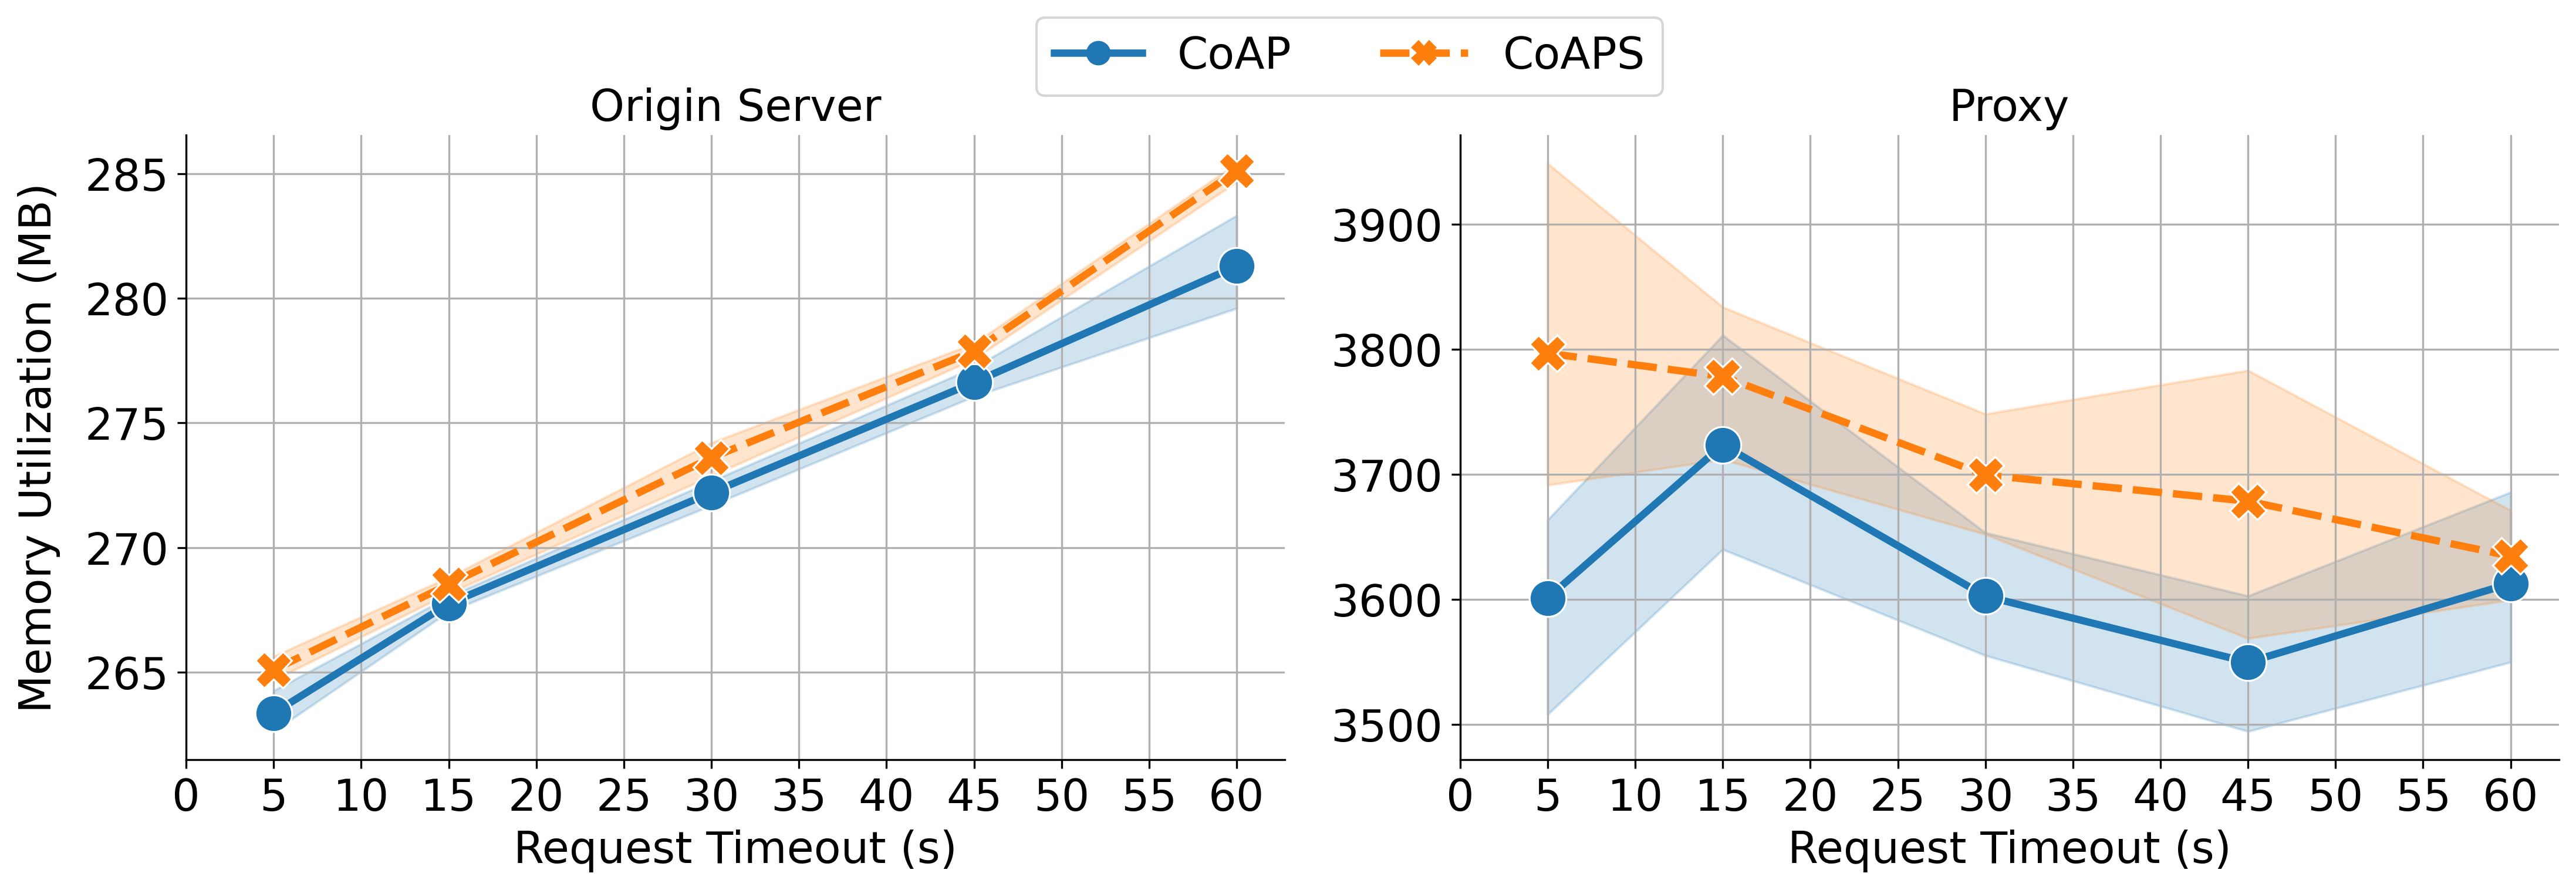

CPU times: user 2.15 s, sys: 192 ms, total: 2.34 s
Wall time: 2.04 s


exp_id  \
2    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
6    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7    thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
10   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                                ...   
191  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
194  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
195  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
198  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
199  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
2        1  Origin Server  MB Memory Utilization   267.271523      242.0   
3        1          Proxy  MB Memory Utilization  3619.836394      248.0   
6        2  Origin Server  MB Memory Utilization   267.986777      244.0   
7        2          Proxy  MB Memory Utilization  3889.191987      249.0   
10       3  Origin Server  MB Memory Utilization   267.537190      244.0   
..     ...            ...                    ...          ...        ...   
191      3          Proxy  MB Memory Utilization  3576.284281      253.0   
194      4  Origin Server  MB Memory Utilization   285.151667      257.0   
195      4          Proxy  MB Memory Utilization  3628.232441      252.0   
198      5  Origin Server  MB Memory Utilization   285.458472      256.0   
199      5          Proxy  MB Memory Utilization  3651.702838      253.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
2        298.0       100mbps                 256                        0   
3       6077.0       100mbps                 256                        0   
6        299.0       100mbps                 256                        0   
7       6569.0       100mbps                 256                        0   
10       289.0       100mbps                 256                        0   
..         ...           ...                 ...                      ...   
191     6216.0       100mbps                 256                        0   
194      333.0       100mbps                 256                        0   
195     6385.0       100mbps                 256                        0   
198      335.0       100mbps                 256                        0   
199     6365.0       100mbps                 256                        0   

     ...                             topology_name  num_proxy_connections  \
2    ...  thesis_cloud_proxy_and_internet_attacker                     50   
3    ...  thesis_cloud_proxy_and_internet_attacker                     50   
6    ...  thesis_cloud_proxy_and_internet_attacker                     50   
7    ...  thesis_cloud_proxy_and_internet_attacker                     50   
10   ...  thesis_cloud_proxy_and_internet_attacker                     50   
..   .

In [87]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)
df = df[df["metric_type"] == "MB Memory Utilization"]

g = sns.relplot(
  data=df,
  kind="line",
  x="request_timeout",
  y="avg_value",
  col="observer_id",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": True,
  },
  aspect=1.50,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Request Timeout (s)")

axes = [
  g.axes[0,0],
  g.axes[0,1],
]
for i, ax in enumerate(axes):
  if i % 2 == 0:
    ax.set_ylabel("Memory Utilization (MB)", labelpad=10)
  else:
    ax.set_ylabel("")
  ax.set_xticks(np.arange(0,61,5))
  ax.grid(True, axis="both")

sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.45, 1.05),
  ncol=2,
  title=None,
  frameon=True,
)

plt.show()

df

In [20]:
(
  df
  .groupby(
    by=["request_timeout", "run_proxy_with_dtls", "observer_id", "metric_type"]
  )
  .agg(
    avg_value=("avg_value", "mean"),
  )
)

avg_value
request_timeout run_proxy_with_dtls observer_id   metric_type                       
5               CoAP                Origin Server % CPU Utilization         5.197571
                                                  MB Memory Utilization   263.359714
                                    Proxy         % CPU Utilization        15.411143
                                                  MB Memory Utilization  3601.032284
                CoAPS               Origin Server % CPU Utilization         5.118286
                                                  MB Memory Utilization   265.093506
                                    Proxy         % CPU Utilization        15.645000
                                                  MB Memory Utilization  3796.707208
15              CoAP                Origin Server % CPU Utilization         6.678429
                                                  MB Memory Utilization   267.748850
                                    Proxy         % CPU Utilization        17.846571
                                                  MB Memory Utilization  3723.440992
                CoAPS               Origin Server % CPU Utilization         6.707143
                                                  MB Memory Utilization   268.521931
                                    Proxy         % CPU Utilization        18.261429
                                                  MB Memory Utilization  3778.131586
30              CoAP                Origin Server % CPU Utilization         8.659143
                                                  MB Memory Utilization   272.204120
                                    Proxy         % CPU Utilization        20.414143
                                                  MB Memory Utilization  3602.582828
                CoAPS               Origin Server % CPU Utilization         8.744857
                                                  MB Memory Utilization   273.604345
                                    Proxy         % CPU Utilization        20.891286
                                                  MB Memory Utilization  3699.379869
45              CoAP                Origin Server % CPU Utilization        11.006857
                                                  MB Memory Utilization   276.624375
                                    Proxy         % CPU Utilization        22.252571
                                                  MB Memory Utilization  3549.692154
                CoAPS               Origin Server % CPU Utilization        11.352857
                                                  MB Memory Utilization   277.876661
                                    Proxy         % CPU Utilization        22.436857
                                                  MB Memory Utilization  3678.465260
60              CoAP                Origin Server % CPU Utilization        13.846143
                                                  MB Memory Utilization   281.289836
                                    Proxy         % CPU Utilization        24.201000
                                                  MB Memory Utilization  3612.749033
                CoAPS               Origin Server % CPU Utilization        13.886714
                                                  MB Memory Utilization   285.113459
                                    Proxy         % CPU Utilization        24.636571
                                                  MB Memory Utilization  3634.505658

In [21]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  df = (
    pl
    .scan_parquet(
      f"{experiment_dir}/*/{exp_id}.connections.parquet"
    )
  )
  lazy_dfs.append(df)

lazy_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)

connections_df = (
  pl
  .concat(lazy_dfs)

  # Filter for proxy's view of syn-acks or fin-acks coming from server
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])

  # And finally convert to pandas for plotting.
  .collect()
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

# This method also does not include a connection count at the last time
# the proxy is meant to be active -- so we fill that value in based on the
# last value.
last_connection_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"], sort=True)
  .agg(
    max_timestamp=("timestamp", "max"),
    last_timestamp=("timestamp", "last"),
    max_open_connections=("open_connections", "max"),
    last_open_connections=("open_connections", "last"),
    last_cum_syn=("cum_syn", "last"),
    last_cum_fin=("cum_fin", "last"),
  )
  .reset_index()
)
# assert last_connection_df["max_timestamp"].equals(last_connection_df["last_timestamp"])
# assert last_connection_df["max_open_connections"].equals(last_connection_df["last_open_connections"])
records = list()
for r in last_connection_df.to_dict(orient="records"):
  records.append({
    "exp_id"          : r["exp_id"],
    "trial"           : r["trial"],
    "observer_id"     : r["observer_id"],
    "timestamp"       : 140,
    "cum_syn"         : r["last_cum_syn"],
    "cum_fin"         : r["last_cum_fin"],
    "open_connections": r["last_open_connections"],
  })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

connections_df

CPU times: user 2min 27s, sys: 4min 43s, total: 7min 10s
Wall time: 28 s


exp_id  \
0     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                ...   
5465  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
5466  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
5467  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
5468  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
5469  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

      trial observer_id   timestamp  cum_syn  cum_fin  open_connections  \
0         1       proxy    0.000000        0        0                 0   
1         1       proxy    0.065019        1        0                 1   
2         1       proxy    2.067345        2        0                 2   
3         1       proxy    3.186998        3        0                 3   
4         1       proxy    6.052259        4        0                 4   
...     ...         ...         ...      ...      ...               ...   
5465      5       proxy  132.344436       52       49                 3   
5466      5       proxy  132.344472       52       50                 2   
5467      5       proxy  132.344504       52       51                 1   
5468      5       proxy  132.344555       52       52                 0   
5469      5       proxy  140.000000       52       52                 0   

     attacker_rate  server_connections  max_keep_alive_requests  ...  \
0          100mbps                 256                        0  ...   
1          100mbps                 256                        0  ...   
2          100mbps                 256                        0  ...   
3          100mbps                 256                        0  ...   
4          100mbps                 256                        0  ...   
...            ...                 ...                      ...  ...   
5465       100mbps                 256                        0  ...   
5466       100mbps                 256                        0  ...   
5467       100mbps                 256                        0  ...   
5468       100mbps                 256                        0  ...   
5469       100mbps                 256                        0  ...   

                                 topology_name  num_proxy_connections  \
0     thesis_cloud_proxy_and_internet_attacker                     50   
1     thesis_cloud_proxy_and_internet_attacker                     50   
2     thesis_cloud_proxy_and_internet_attacker                     50   
3     thesis_cloud_proxy_and_internet_attacker                     50   
4     thesis_cloud_proxy_and_internet_attacker                     50   
...                                        ...                    ...   
5465  thesis_cloud

In [22]:
%%time

max_timestamp = np.ceil(connections_df.timestamp.max())
min_timestamp = np.floor(connections_df.timestamp.min())
steps = np.arange(min_timestamp, max_timestamp + 1, 5)

filled_connections_df = (
  connections_df
  .groupby(by=[
    "exp_id", "observer_id", "trial",
    pd.cut(connections_df["timestamp"], steps)
  ], sort=True)
  .agg(
    open_connections=("open_connections", "mean"),
  )
  .fillna(method="ffill")
  .reset_index()
)

filled_connections_df["timestamp"] = filled_connections_df["timestamp"].map(operator.attrgetter("right"))
filled_connections_df = filled_connections_df.merge(exp_df, on="exp_id", how="left")
filled_connections_df = filled_connections_df.replace(value_map_replacement)

filled_connections_df

CPU times: user 78.1 ms, sys: 4.75 ms, total: 82.9 ms
Wall time: 81 ms


exp_id  \
0     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                ...   
1395  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1396  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1397  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1398  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1399  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     observer_id  trial timestamp  open_connections attacker_rate  \
0          proxy      1       5.0               2.0       100mbps   
1          proxy      1      10.0               4.0       100mbps   
2          proxy      1      15.0               5.0       100mbps   
3          proxy      1      20.0               5.0       100mbps   
4          proxy      1      25.0               6.5       100mbps   
...          ...    ...       ...               ...           ...   
1395       proxy      5     120.0              28.5       100mbps   
1396       proxy      5     125.0              28.5       100mbps   
1397       proxy      5     130.0              28.5       100mbps   
1398       proxy      5     135.0              24.5       100mbps   
1399       proxy      5     140.0               0.0       100mbps   

      server_connections  max_keep_alive_requests  num_clients  num_trials  \
0                    256                        0            8           5   
1                    256                        0            8           5   
2                    256                        0            8           5   
3                    256                        0            8           5   
4                    256                        0            8           5   
...                  ...                      ...          ...         ...   
1395                 256                        0            8           5   
1396                 256                        0            8           5   
1397                 256                        0            8           5   
1398                 256                        0            8           5   
1399                 256                        0            8           5   

      ...                             topology_name  num_proxy_connections  \
0     ...  thesis_cloud_proxy_and_internet_attacker                     50   
1     ...  thesis_cloud_proxy_and_internet_attacker                     50   
2     ...  thesis_cloud_proxy_and_internet_attacker                     50   
3     ...  thesis_cloud_proxy_and_internet_attacker                     50   
4     ...  thesis_cloud_proxy_and_internet_attacker                     50   
...   ...                                       ...          

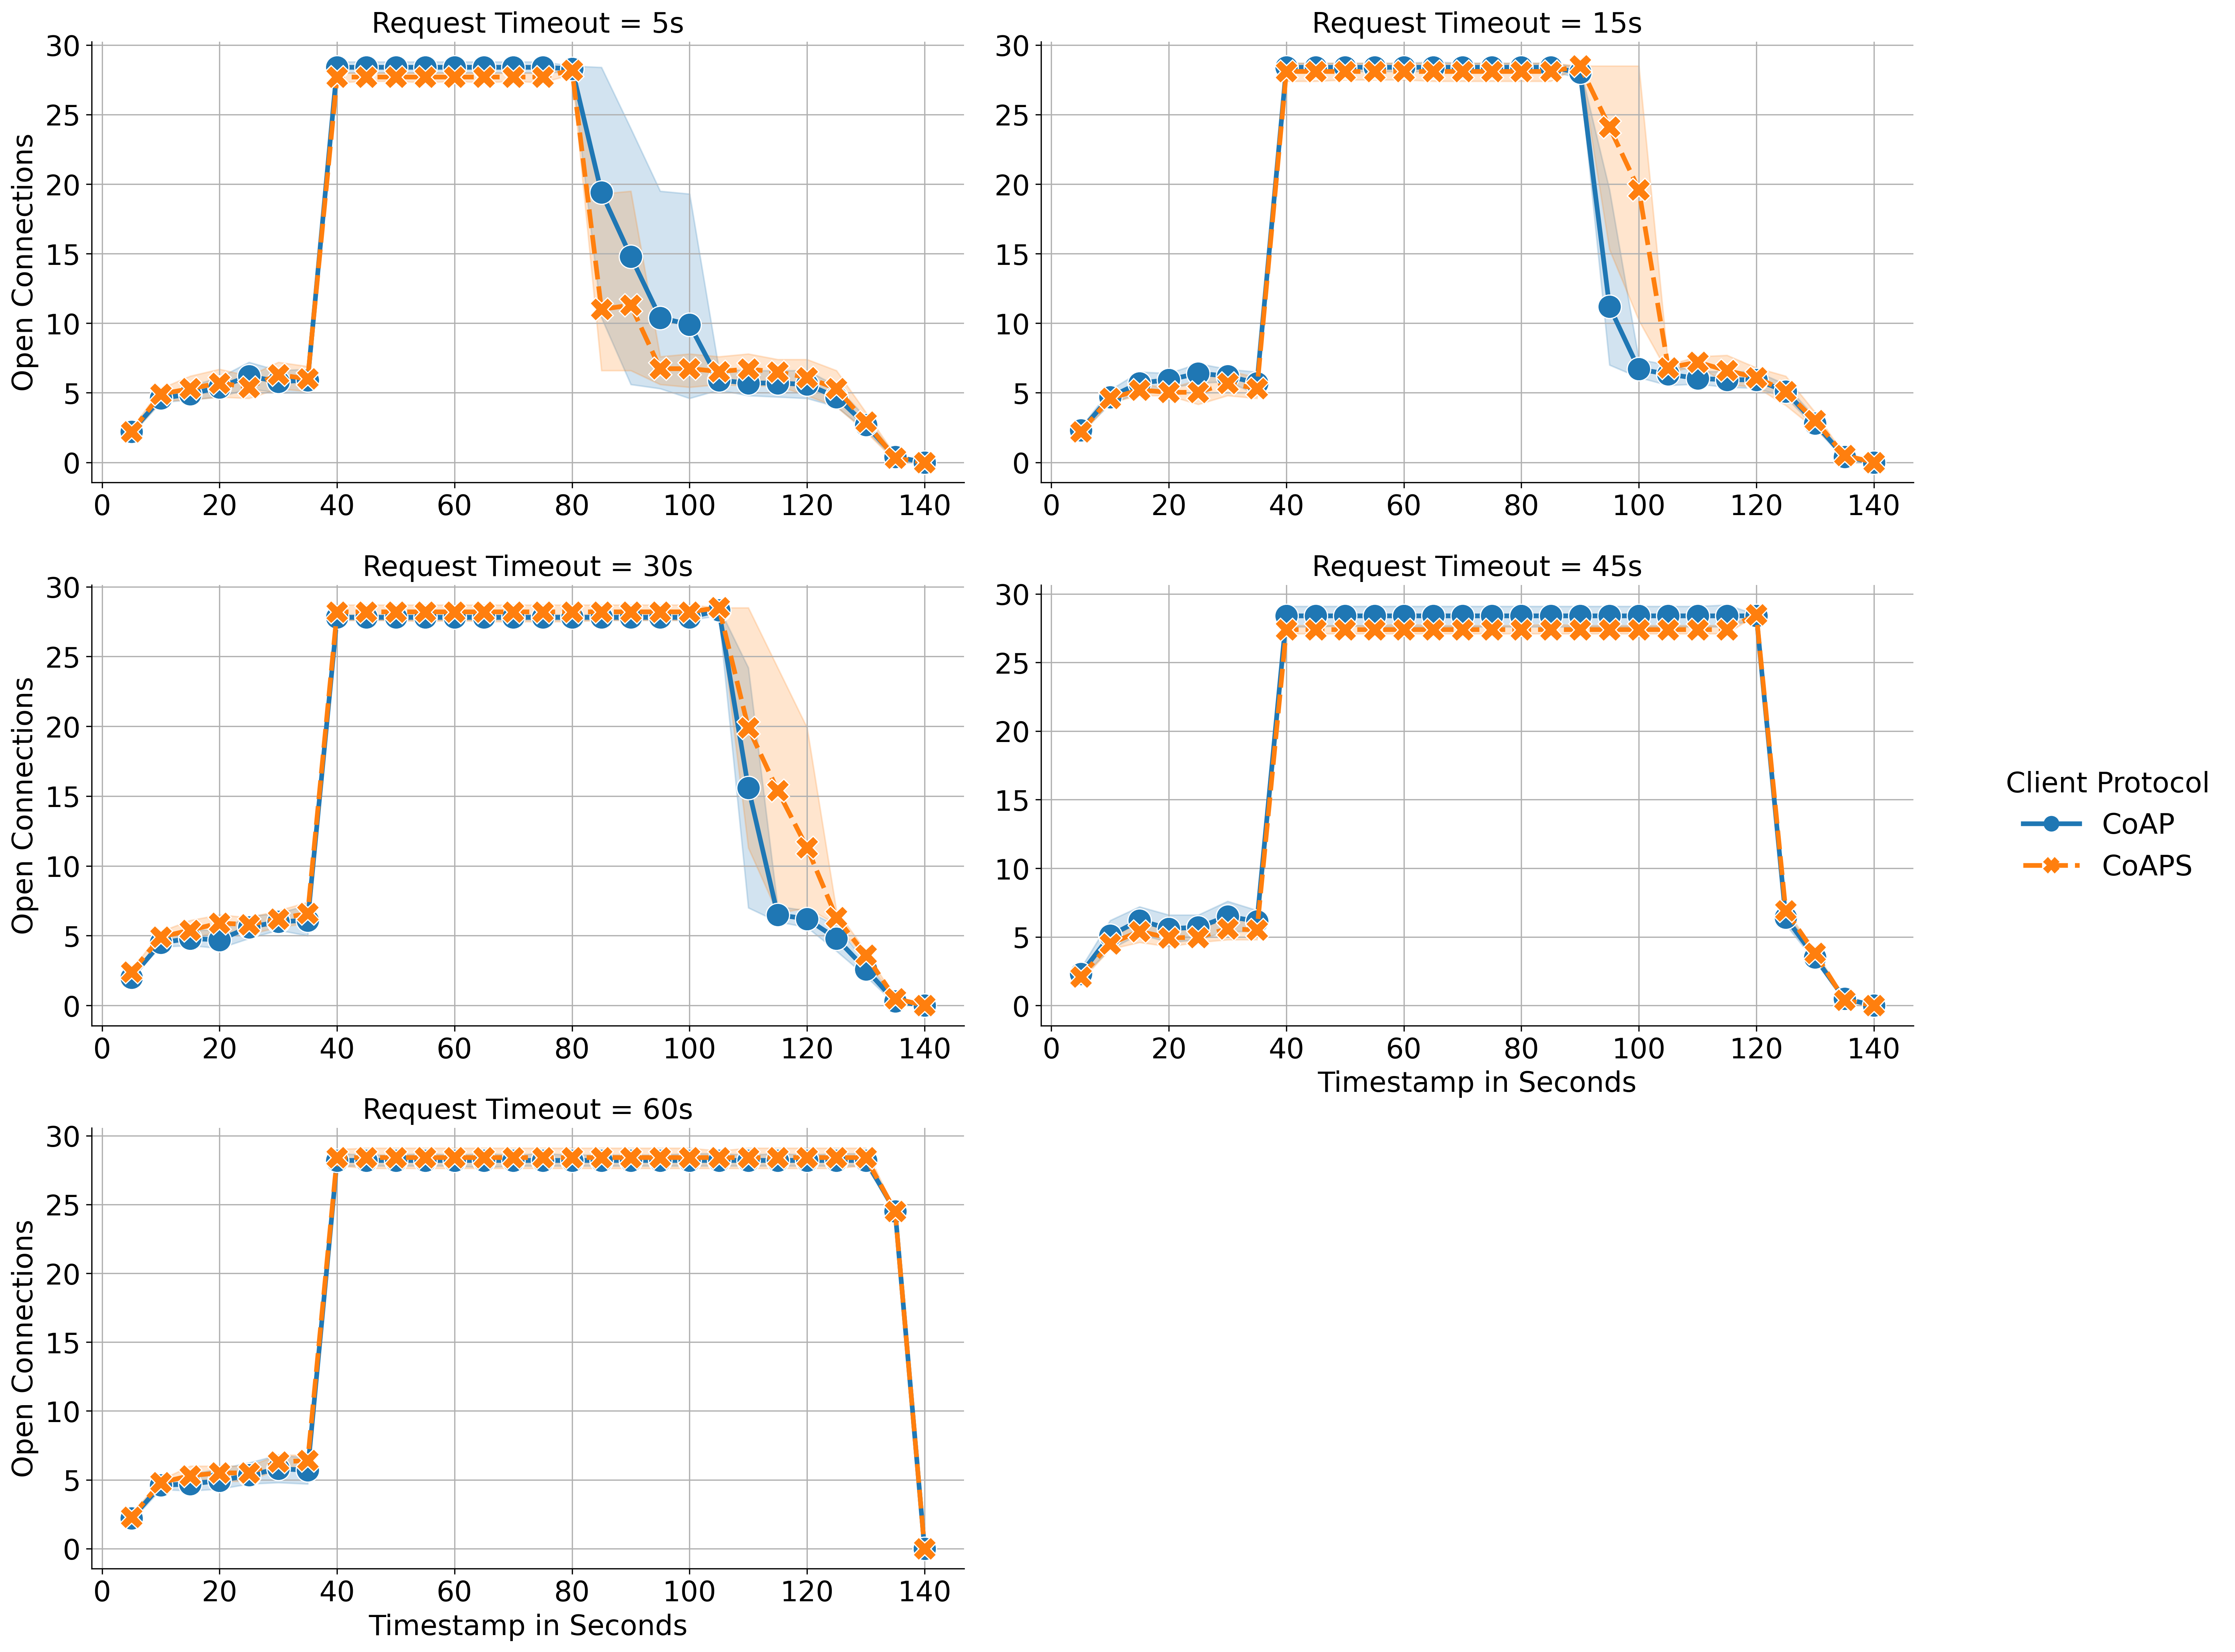

CPU times: user 12.7 s, sys: 485 ms, total: 13.1 s
Wall time: 12.8 s


In [23]:
%%time

## Measure proxy and server connection management.

df = filled_connections_df

g = sns.relplot(
  data=df,
  kind="line",
  x="timestamp",
  y="open_connections",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="request_timeout",
  col_wrap=2,
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
  aspect=1.75,
)
g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Open Connections")
g.legend.set_title("Client Protocol")

g.set_titles(
  template="Request Timeout = {col_name}s",
  col_template="{col_name}",
  row_template="{row_name}",
)

# g.set(yticks=np.arange(1,9,1))
for i in range(5):
  g.axes[i].grid(True, axis="both")

plt.grid(True, axis="y")
plt.show()

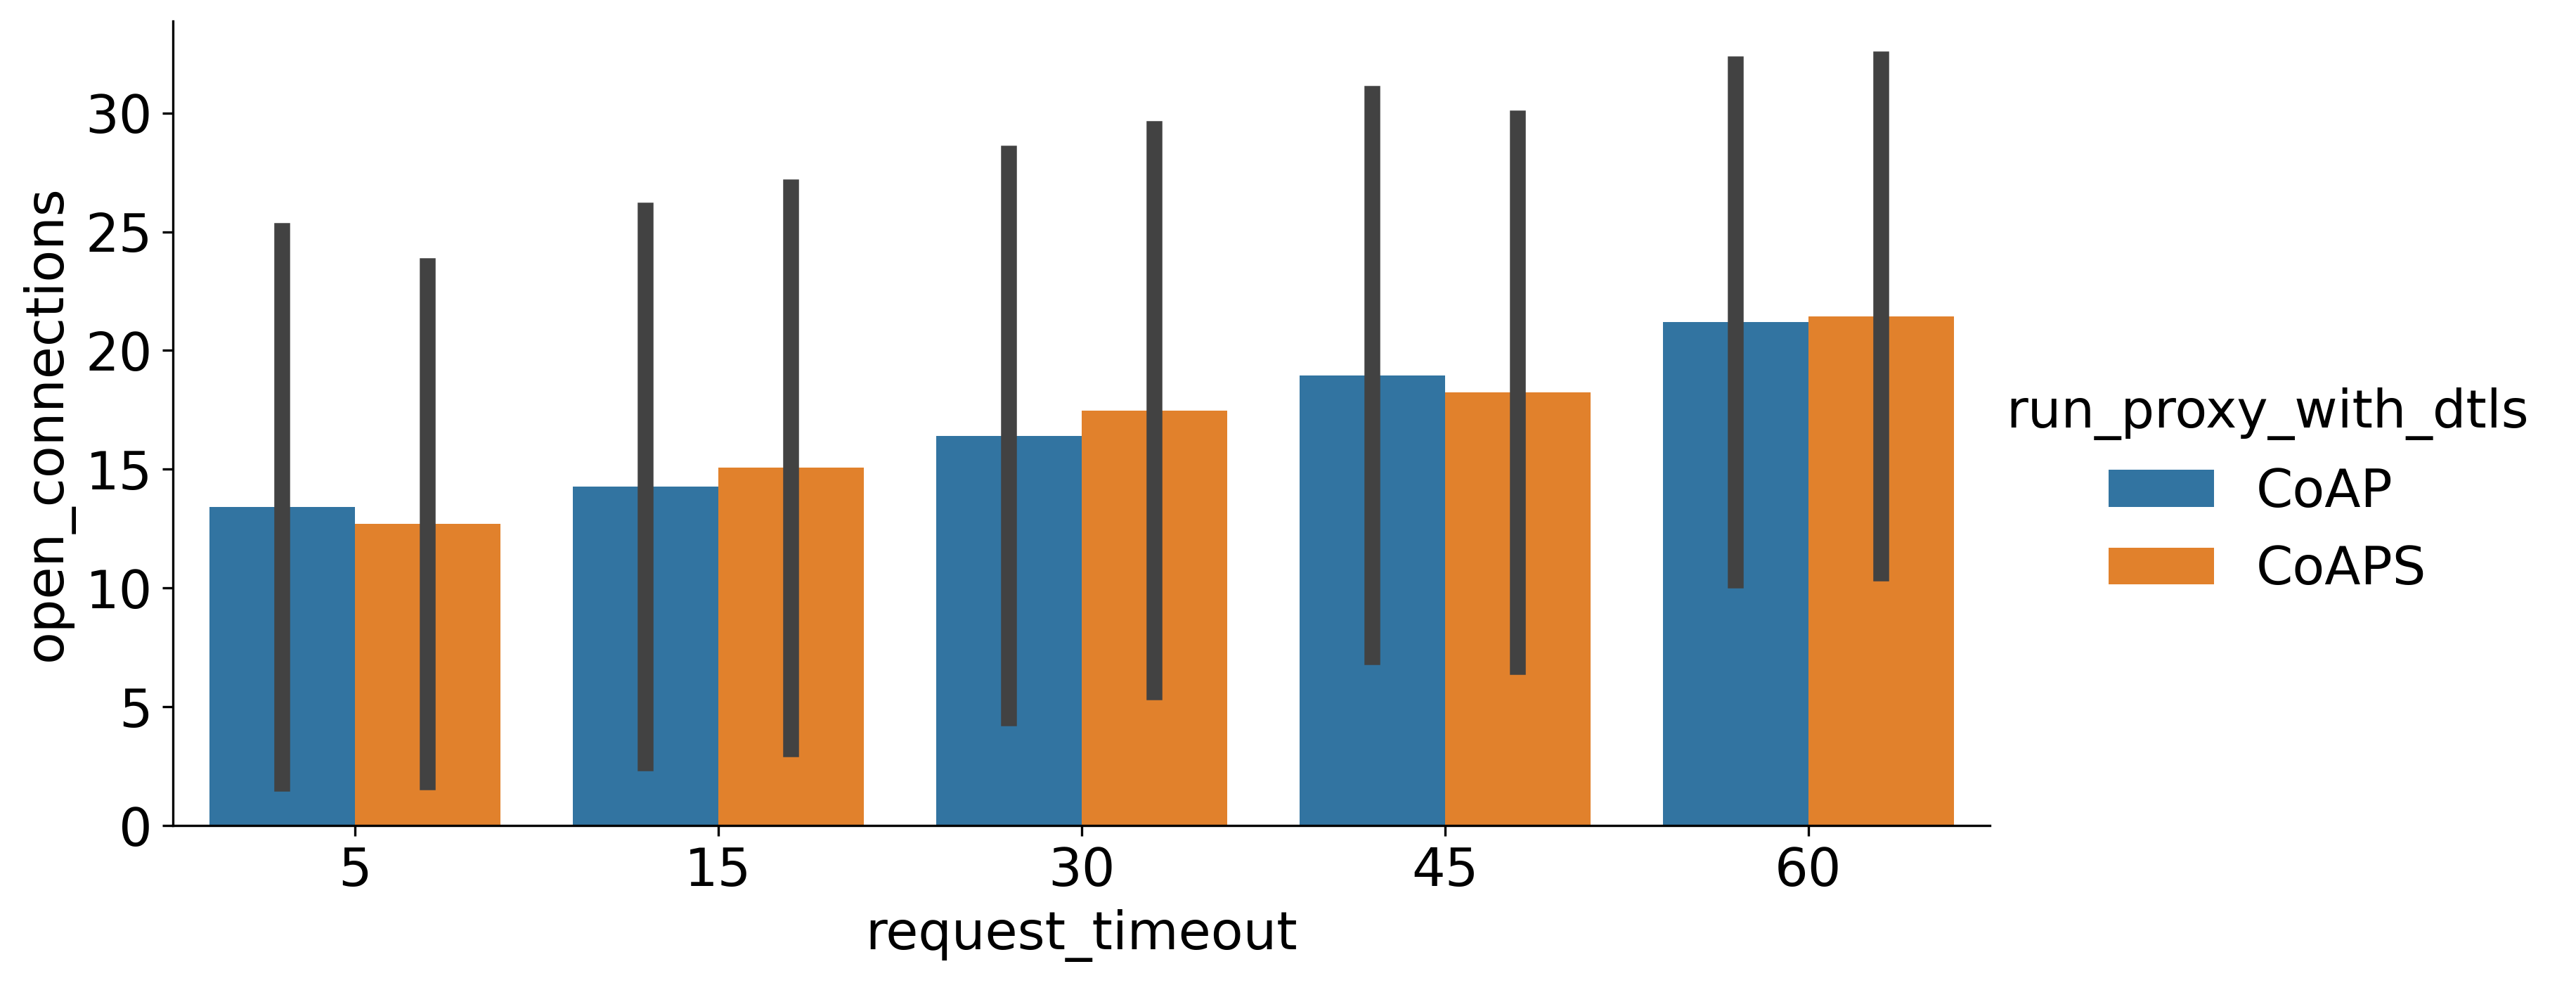

CPU times: user 1.1 s, sys: 160 ms, total: 1.26 s
Wall time: 949 ms


exp_id  \
0     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4     thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                ...   
1395  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1396  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1397  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1398  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1399  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     observer_id  trial timestamp  open_connections attacker_rate  \
0          proxy      1       5.0               2.0       100mbps   
1          proxy      1      10.0               4.0       100mbps   
2          proxy      1      15.0               5.0       100mbps   
3          proxy      1      20.0               5.0       100mbps   
4          proxy      1      25.0               6.5       100mbps   
...          ...    ...       ...               ...           ...   
1395       proxy      5     120.0              28.5       100mbps   
1396       proxy      5     125.0              28.5       100mbps   
1397       proxy      5     130.0              28.5       100mbps   
1398       proxy      5     135.0              24.5       100mbps   
1399       proxy      5     140.0               0.0       100mbps   

      server_connections  max_keep_alive_requests  num_clients  num_trials  \
0                    256                        0            8           5   
1                    256                        0            8           5   
2                    256                        0            8           5   
3                    256                        0            8           5   
4                    256                        0            8           5   
...                  ...                      ...          ...         ...   
1395                 256                        0            8           5   
1396                 256                        0            8           5   
1397                 256                        0            8           5   
1398                 256                        0            8           5   
1399                 256                        0            8           5   

      ...                             topology_name  num_proxy_connections  \
0     ...  thesis_cloud_proxy_and_internet_attacker                     50   
1     ...  thesis_cloud_proxy_and_internet_attacker                     50   
2     ...  thesis_cloud_proxy_and_internet_attacker                     50   
3     ...  thesis_cloud_proxy_and_internet_attacker                     50   
4     ...  thesis_cloud_proxy_and_internet_attacker                     50   
...   ...                                       ...          

In [24]:
%%time

g = sns.catplot(
  data=filled_connections_df,
  kind="bar",
  x="request_timeout",
  y="open_connections",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

plt.show()

filled_connections_df

In [35]:
%%time 

client_journey_sql = f"""
WITH client_sends AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
),

proxy_events AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, proxy_dnids))})   -- proxy dnids
),

client_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.observer_id AS observer_id,
  client_sends.trial AS trial,
  client_sends.message_marker AS message_marker,
  (groupArray(client_recvs.coap_code))[1] AS coap_code,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  abs(1e3 * (MIN(proxy_events.observe_timestamp) - MIN(client_sends.observe_timestamp))) AS client_to_proxy_ms,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(proxy_events.observe_timestamp)) AS proxy_to_client_ms,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS client_to_self_rtt_ms,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec
FROM
  client_sends
  JOIN proxy_events
    ON proxy_events.exp_id = client_sends.exp_id
    AND proxy_events.trial = client_sends.trial
    AND proxy_events.message_marker = client_sends.message_marker
  JOIN client_recvs
    ON client_recvs.exp_id = proxy_events.exp_id
    AND client_recvs.trial = proxy_events.trial
    AND client_recvs.message_marker = proxy_events.message_marker
    AND client_recvs.observer_id = client_sends.observer_id
GROUP BY
  client_sends.exp_id, client_sends.observer_id, client_sends.trial, client_sends.message_marker
ORDER BY
  exp_id, trial, message_marker, first_send_time_sec
"""

client_journey_df = client.query_dataframe(client_journey_sql)

client_journey_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_journey_df

CPU times: user 1.71 s, sys: 681 ms, total: 2.39 s
Wall time: 1min 37s


exp_id  \
0       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4       thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                  ...   
440430  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440431  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440432  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440433  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
440434  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

       observer_id  trial  message_marker    coap_code  first_send_time_sec  \
0          client1      1               1      content             0.000000   
1          client1      1               2      content             0.368913   
2          client1      1               3      content             0.431380   
3          client1      1               4      content             0.492094   
4          client1      1               5      content             0.551819   
...            ...    ...             ...          ...                  ...   
440430     client8      5           95827      content            41.092547   
440431     client4      5           95841      content            41.093082   
440432     client3      5          141796      content            43.001816   
440433     client6      5          272895      content            48.433947   
440434     client3      5          547200  bad_gateway            59.800405   

        client_to_proxy_ms  proxy_to_client_ms  client_to_self_rtt_ms  \
0                19.864082          331.251860             351.115942   
1                19.842148           40.149927              59.992075   
2                19.794941           38.521051              58.315992   
3                19.841909           37.425995              57.267904   
4                19.814968           36.869049              56.684017   
...                    ...                 ...                    ...   
440430           20.431995        42806.649923           42827.081919   
440431           20.894051        21912.747860           21933.641911   
440432           20.787001        16776.519775           16797.306776   
440433           20.431995        37118.803978           37139.235973   
440434           20.787001        60020.885944           60041.672945   

        first_recv_time_sec  
0                  0.351116  
1                  0.428905  
2                  0.489696  
3                  0.549362  
4                  0.608503  
...                     ...  
440430            83.919629  
440431            63.026724  
440432            59.799123  
440433            85.573183  
440434           119.842078  

[440435 rows x 10 columns]

In [36]:
%%time

# `client_journey_df` is far too detailed for plotting, but
# is useful for non-plotting use-cases so we keep it around.
# But for plotting, we summarize RTTs in discrete intervals
# of time instead, thus reducing the amount of data.

reduced_client_journey_df = (
  client_journey_df
  .groupby(by=[
    "exp_id", "observer_id", "trial",
    pd.cut(client_journey_df["first_send_time_sec"], np.arange(0,121,5))
  ])
  .agg(
    client_to_proxy_ms=("client_to_proxy_ms", "mean"),
    proxy_to_client_ms=("proxy_to_client_ms", "mean"),
    client_to_self_rtt_ms=("client_to_self_rtt_ms", "mean"),
  )
  .reset_index()
  .melt(
    id_vars=["exp_id", "observer_id", "trial", "first_send_time_sec"],
    value_vars=["client_to_proxy_ms", "proxy_to_client_ms", "client_to_self_rtt_ms"],
    var_name="sub_journey_name",
    value_name="sub_journey_time_ms",
  )
)

reduced_client_journey_df["first_send_time_sec"] = reduced_client_journey_df["first_send_time_sec"].map(operator.attrgetter("right"))
reduced_client_journey_df = reduced_client_journey_df.merge(exp_df, on="exp_id", how="left")

reduced_client_journey_df

CPU times: user 711 ms, sys: 83 µs, total: 711 ms
Wall time: 721 ms


exp_id  \
0      thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1      thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2      thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3      thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4      thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                 ...   
28795  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28796  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28797  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28798  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28799  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

      observer_id  trial first_send_time_sec       sub_journey_name  \
0         client1      1                   5     client_to_proxy_ms   
1         client1      1                  10     client_to_proxy_ms   
2         client1      1                  15     client_to_proxy_ms   
3         client1      1                  20     client_to_proxy_ms   
4         client1      1                  25     client_to_proxy_ms   
...           ...    ...                 ...                    ...   
28795     client8      5                 100  client_to_self_rtt_ms   
28796     client8      5                 105  client_to_self_rtt_ms   
28797     client8      5                 110  client_to_self_rtt_ms   
28798     client8      5                 115  client_to_self_rtt_ms   
28799     client8      5                 120  client_to_self_rtt_ms   

       sub_journey_time_ms attacker_rate  server_connections  \
0                19.794516       100mbps                 256   
1                19.769433       100mbps                 256   
2                19.694266       100mbps                 256   
3                19.652805       100mbps                 256   
4                19.647506       100mbps                 256   
...                    ...           ...                 ...   
28795                  NaN       100mbps                 256   
28796                  NaN       100mbps                 256   
28797                  NaN       100mbps                 256   
28798                  NaN       100mbps                 256   
28799                  NaN       100mbps                 256   

       max_keep_alive_requests  num_clients  ...  \
0                            0            8  ...   
1                            0            8  ...   
2                            0            8  ...   
3                            0            8  ...   
4                            0            8  ...   
...                        ...          ...  ...   
28795                        0            8  ...   
28796                        0            8  ...   
28797                        0            8  ...   
28798                        0            8  ...   
28799                        0            8  ...   

                                  top

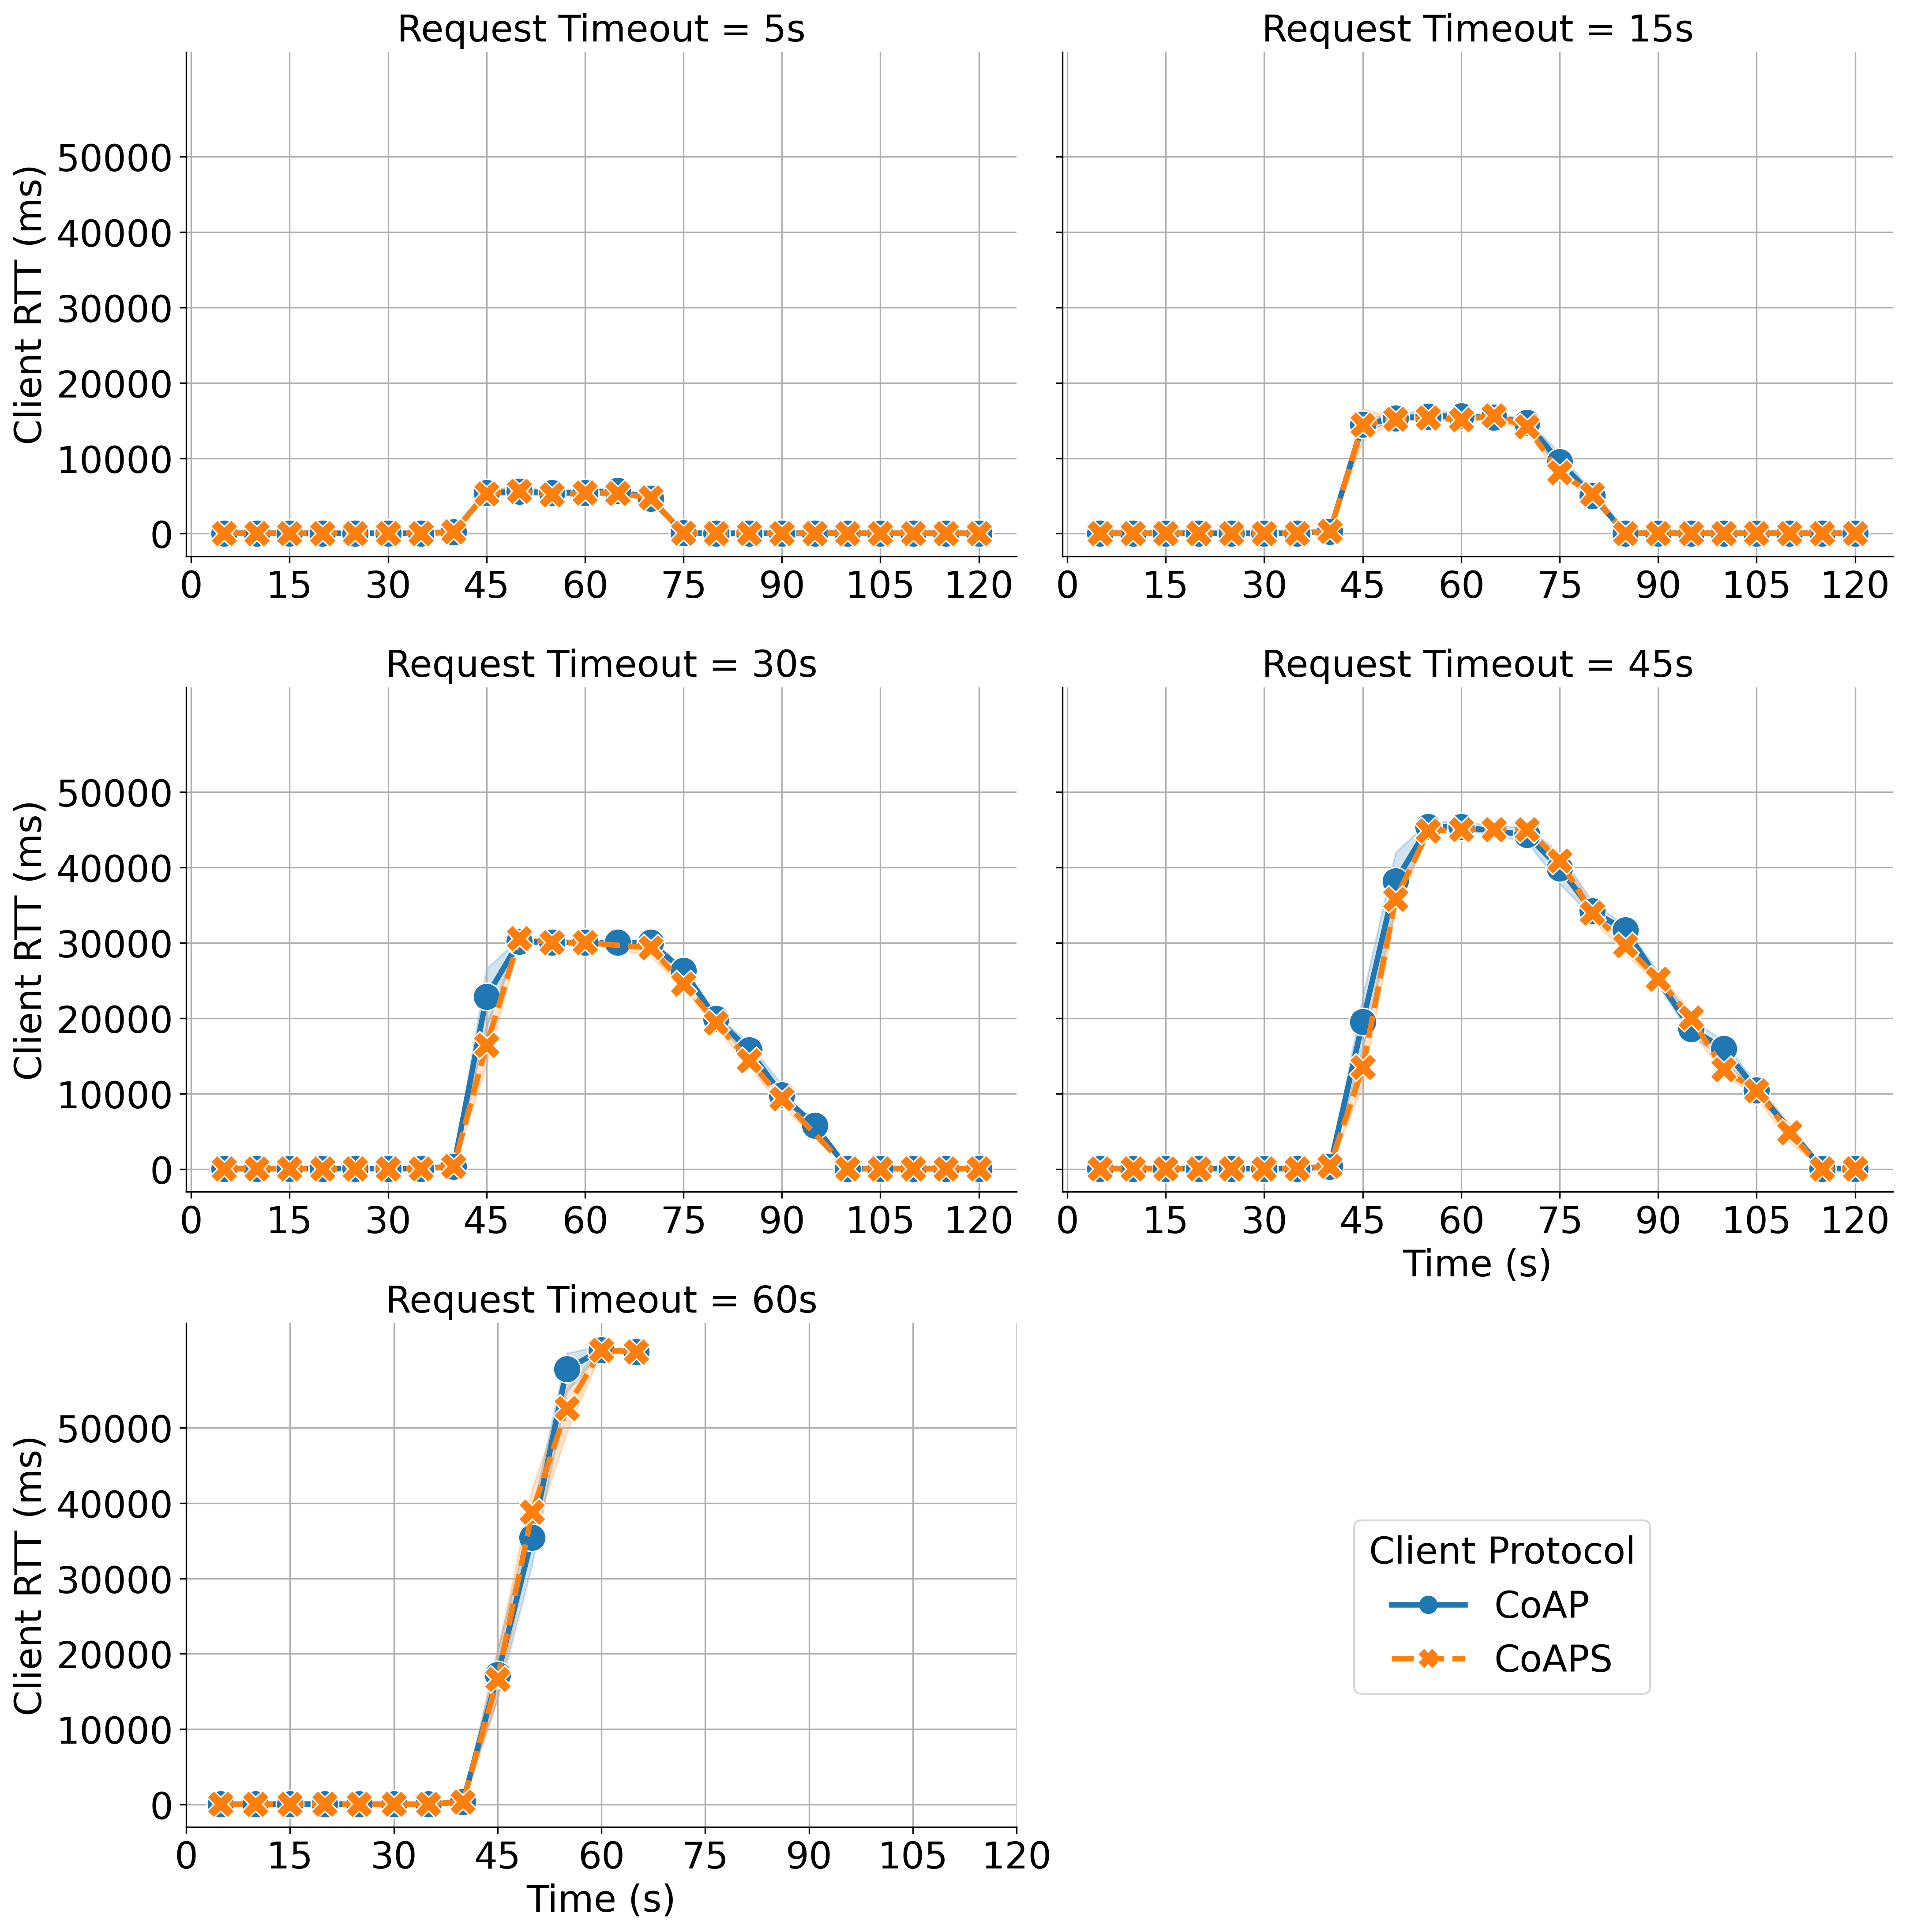

CPU times: user 9.35 s, sys: 215 ms, total: 9.56 s
Wall time: 9.27 s


exp_id  \
19200  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
19201  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
19202  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
19203  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
19204  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                 ...   
28795  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28796  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28797  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28798  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
28799  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

      observer_id  trial first_send_time_sec       sub_journey_name  \
19200     client1      1                   5  client_to_self_rtt_ms   
19201     client1      1                  10  client_to_self_rtt_ms   
19202     client1      1                  15  client_to_self_rtt_ms   
19203     client1      1                  20  client_to_self_rtt_ms   
19204     client1      1                  25  client_to_self_rtt_ms   
...           ...    ...                 ...                    ...   
28795     client8      5                 100  client_to_self_rtt_ms   
28796     client8      5                 105  client_to_self_rtt_ms   
28797     client8      5                 110  client_to_self_rtt_ms   
28798     client8      5                 115  client_to_self_rtt_ms   
28799     client8      5                 120  client_to_self_rtt_ms   

       sub_journey_time_ms attacker_rate  server_connections  \
19200            54.546698       100mbps                 256   
19201            53.674093       100mbps                 256   
19202            52.934543       100mbps                 256   
19203            52.742697       100mbps                 256   
19204            52.596002       100mbps                 256   
...                    ...           ...                 ...   
28795                  NaN       100mbps                 256   
28796                  NaN       100mbps                 256   
28797                  NaN       100mbps                 256   
28798                  NaN       100mbps                 256   
28799                  NaN       100mbps                 256   

       max_keep_alive_requests  num_clients  ...  \
19200                        0            8  ...   
19201                        0            8  ...   
19202                        0            8  ...   
19203                        0            8  ...   
19204                        0            8  ...   
...                        ...          ...  ...   
28795                        0            8  ...   
28796                        0            8  ...   
28797                        0            8  ...   
28798                        0            8  ...   
28799                        0            8  ...   

                                  top

In [44]:
%%time

## Plot different stages of the client round-trip.

plt.rcParams['font.size'] = '20'
plt.rcParams.update({'figure.autolayout': True})

df = (
  reduced_client_journey_df[
    reduced_client_journey_df["sub_journey_name"] == "client_to_self_rtt_ms"
  ]
  .replace(value_map_replacement)
)

g = sns.relplot(
  data=df,
  kind="line",
  x="first_send_time_sec",
  y="sub_journey_time_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="request_timeout",
  col_wrap=2,
  markers=True,
  markersize=15,
  aspect=1.5,
  facet_kws={
    "sharey": True,
    "sharex": False,
  },
)

g.set_xlabels("Time (s)")
g.set_ylabels("Client RTT (ms)")
g.legend.set_title("Client Protocol")

g.set_titles(
  template="Request Timeout = {col_name}s",
  col_template="{col_name}",
  row_template="{row_name}",
)

g.set(
  yticks=np.arange(0,50_001, 10_000),
  xticks=np.arange(0, 121, 15),
)

for i in range(len(df["request_timeout"].unique())):
  g.axes[i].grid(True, axis="both")

sns.move_legend(
  g,
  "upper center",
  # bbox_to_anchor=(0.42, 1.05),
  bbox_to_anchor=(0.66, 0.23),
  # ncol=2,
  frameon=True,
  # title=None,
)

plt.show()

df

In [ ]:
for r in sorted(df["request_timeout"].unique()):
  for p in sorted(df["run_proxy_with_dtls"].unique()):
    if r == 60:
      continue
    tdf = df[
      (df["sub_journey_time_ms"] > 1_000)
      & (df["first_send_time_sec"] > 60)
      & (df["request_timeout"] == r)
      & (df["run_proxy_with_dtls"] == p)
    ]
    max_df = tdf.loc[tdf["sub_journey_time_ms"].idxmax()]

    fdf = df[
      (df["sub_journey_time_ms"] < 500)
      & (df["first_send_time_sec"] > 70)
      & (df["request_timeout"] == r)
      & (df["run_proxy_with_dtls"] == p)
    ]
    min_df = fdf.loc[fdf["first_send_time_sec"].idxmin()]

    max_rtt = max_df['sub_journey_time_ms']
    max_timestamp = max_df['first_send_time_sec']

    min_rtt = min_df['sub_journey_time_ms']
    min_timestamp = min_df['first_send_time_sec']

    slope = (max_rtt - min_rtt) / (max_timestamp - min_timestamp)

    print(f"{r=}, {p=}, {slope=}")

r=5, p='CoAP', slope=-931.2863539565693
r=5, p='CoAPS', slope=-833.948055267334
r=15, p='CoAP', slope=-891.6151567381255
r=15, p='CoAPS', slope=-1089.8741387853436
r=30, p='CoAP', slope=-857.0652192124479
r=30, p='CoAPS', slope=-1000.6010940239864
r=45, p='CoAP', slope=-1039.3115787741579
r=45, p='CoAPS', slope=-900.0930092884944


In [ ]:
%%time 

attacker_messages_sql = f"""
WITH attacker_sends AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, attacker_dnids))})   -- attacker dnids
  AND m.src_id IN ({','.join(map(str, attacker_node_ids))}) -- attackers are senders (node ID)
),

proxy_events AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, proxy_dnids))})   -- proxy dnids
),

attacker_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, attacker_dnids))})   -- attacker dnids
  AND m.dst_id IN ({','.join(map(str, attacker_node_ids))}) -- attackers are receivers (node ID)
)

SELECT
  attacker_sends.exp_id AS exp_id,
  attacker_sends.observer_id AS observer_id,
  attacker_sends.trial AS trial,
  attacker_sends.message_marker AS message_marker,
  (groupArray(attacker_recvs.coap_code))[1] AS coap_code,
  MIN(attacker_sends.observe_timestamp) AS first_send_time_sec,
  abs(1e3 * (MIN(proxy_events.observe_timestamp) - MIN(attacker_sends.observe_timestamp))) AS attacker_to_proxy_ms,
  1e3 * (MAX(attacker_recvs.observe_timestamp) - MIN(proxy_events.observe_timestamp)) AS proxy_to_attacker_ms,
  1e3 * (MAX(attacker_recvs.observe_timestamp) - MIN(attacker_sends.observe_timestamp)) AS attacker_to_self_rtt_ms,
  MIN(attacker_recvs.observe_timestamp) AS first_recv_time_sec
FROM
  attacker_sends
  JOIN proxy_events
    ON proxy_events.exp_id = attacker_sends.exp_id
    AND proxy_events.trial = attacker_sends.trial
    AND proxy_events.message_marker = attacker_sends.message_marker
  JOIN attacker_recvs
    ON attacker_recvs.exp_id = proxy_events.exp_id
    AND attacker_recvs.trial = proxy_events.trial
    AND attacker_recvs.message_marker = proxy_events.message_marker
    AND attacker_recvs.observer_id = attacker_sends.observer_id
GROUP BY
  attacker_sends.exp_id, attacker_sends.observer_id, attacker_sends.trial, attacker_sends.message_marker
ORDER BY
  exp_id, trial, message_marker, first_send_time_sec
"""

attacker_journey_df = client.query_dataframe(attacker_messages_sql)

attacker_journey_df.observer_id.replace(dnid_map_node_name, inplace=True)

attacker_journey_df

Error on localhost:9000 ping: Unexpected EOF while reading bytes
Connection was closed, reconnecting.
Error on socket shutdown: [Errno 107] Transport endpoint is not connected


KeyboardInterrupt: 

In [59]:
%%time

attacker_message_sql = f"""
WITH attacker_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, attacker_dnids))})   -- attacker dnids
  AND m.dst_id IN ({','.join(map(str, attacker_node_ids))}) -- attackers are receivers (node ID)
),

attacker_response_breakdown AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    coap_code AS response_code,
    COUNT(coap_code) AS response_code_count
  FROM
    attacker_recvs
  GROUP BY
    exp_id, trial, observer_id, response_code
  ORDER BY
    exp_id, trial, observer_id, response_code
),

attacker_response_count AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    SUM(response_code_count) AS response_count
  FROM
    attacker_response_breakdown
  GROUP BY
    exp_id, trial, observer_id
  ORDER BY
    exp_id, trial, observer_id
)

SELECT * FROM attacker_response_breakdown
"""

attacker_message_df = client.query_dataframe(attacker_message_sql)

attacker_message_df.observer_id.replace(dnid_map_node_name, inplace=True)
attacker_message_df = attacker_message_df.merge(exp_df, on="exp_id", how="left")

attacker_message_df

CPU times: user 2.52 s, sys: 460 ms, total: 2.98 s
Wall time: 25.8 s


exp_id  \
0   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
95  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
96  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
97  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
98  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
99  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

    trial observer_id response_code  response_code_count attacker_rate  \
0       1    attacker   bad_gateway               455256       100mbps   
1       1    attacker       content               160317       100mbps   
2       2    attacker   bad_gateway               499609       100mbps   
3       2    attacker       content               154332       100mbps   
4       3    attacker   bad_gateway               470210       100mbps   
..    ...         ...           ...                  ...           ...   
95      3    attacker       content               378256       100mbps   
96      4    attacker   bad_gateway               218355       100mbps   
97      4    attacker       content               379283       100mbps   
98      5    attacker   bad_gateway               222276       100mbps   
99      5    attacker       content               378858       100mbps   

    server_connections  max_keep_alive_requests  num_clients  num_trials  ...  \
0                  256                        0            8           5  ...   
1                  256                        0            8           5  ...   
2                  256                        0            8           5  ...   
3                  256                        0            8           5  ...   
4                  256                        0            8           5  ...   
..                 ...                      ...          ...         ...  ...   
95                 256                        0            8           5  ...   
96                 256                        0            8           5  ...   
97                 256                        0            8           5  ...   
98                 256                        0            8           5  ...   
99                 256                        0            8           5  ...   

                               topology_name  num_proxy_connections  \
0   thesis_cloud_proxy_and_internet_attacker                     50   
1   thesis_cloud_proxy_and_internet_attacker                     50   
2   thesis_cloud_proxy_and_internet_attacker                     50   
3   thesis_cloud_proxy_and_internet_attacker                     50   
4   thesis_cloud_proxy_and_internet_attacker                     50   
..                           

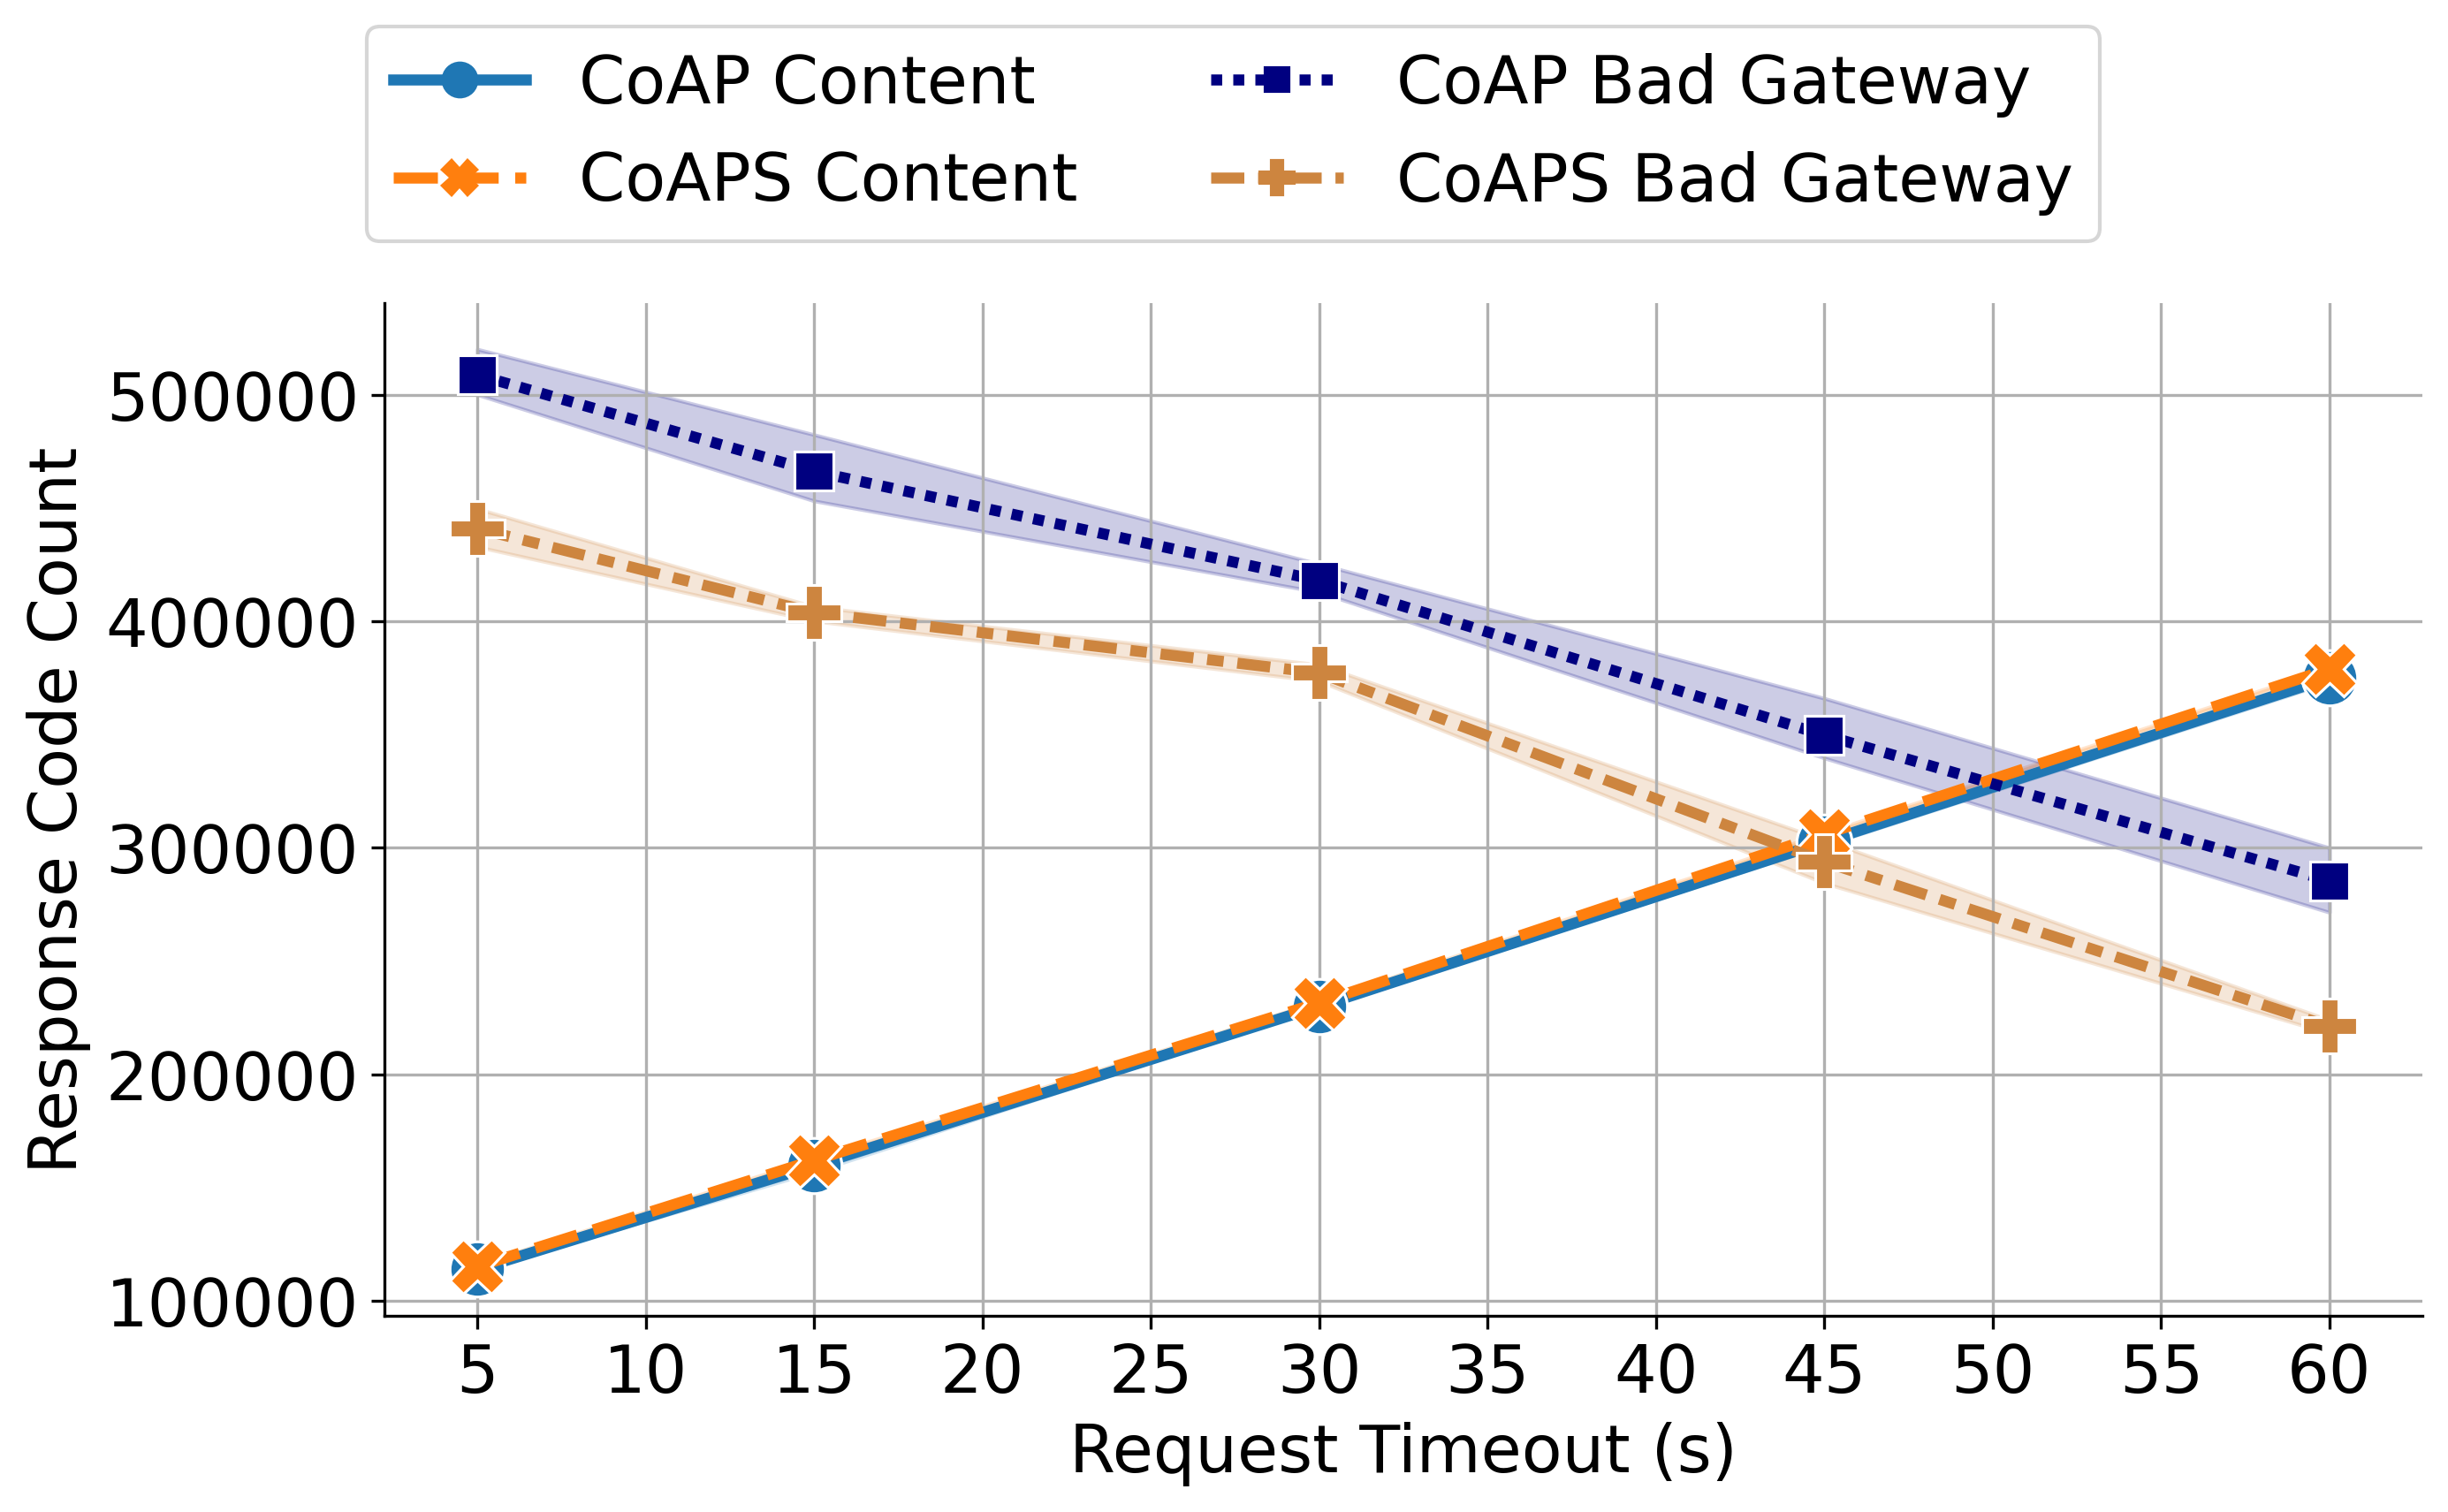

CPU times: user 2 s, sys: 144 ms, total: 2.15 s
Wall time: 1.83 s


exp_id  \
1   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
9   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
90  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
92  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
94  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
96  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
98  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

    trial observer_id Response Code  response_code_count attacker_rate  \
1       1    attacker       Content               160317       100mbps   
3       2    attacker       Content               154332       100mbps   
5       3    attacker       Content               159700       100mbps   
7       4    attacker       Content               162734       100mbps   
9       5    attacker       Content               161082       100mbps   
..    ...         ...           ...                  ...           ...   
90      1    attacker   Bad Gateway               226229       100mbps   
92      2    attacker   Bad Gateway               222250       100mbps   
94      3    attacker   Bad Gateway               216436       100mbps   
96      4    attacker   Bad Gateway               218355       100mbps   
98      5    attacker   Bad Gateway               222276       100mbps   

    server_connections  max_keep_alive_requests  num_clients  num_trials  ...  \
1                  256                        0            8           5  ...   
3                  256                        0            8           5  ...   
5                  256                        0            8           5  ...   
7                  256                        0            8           5  ...   
9                  256                        0            8           5  ...   
..                 ...                      ...          ...         ...  ...   
90                 256                        0            8           5  ...   
92                 256                        0            8           5  ...   
94                 256                        0            8           5  ...   
96                 256                        0            8           5  ...   
98                 256                        0            8           5  ...   

    num_proxy_connections  request_timeout  max_retries  keep_alive_duration  \
1                      50               15            2                    5   
3                      50               15            2                    5   
5                      50               15            2                    5   
7                      50               15            2                    5   
9                      50               15            2

In [68]:
%%time

df = (
  attacker_message_df
  .replace(value_map_replacement)
  .rename(columns={
    "response_code": "Response Code",
    "run_proxy_with_dtls": "Client Protocol",
  })
)
df.sort_values(
  by=["Response Code", "Client Protocol"],
  ascending=[False, True],
  inplace=True,
)
df["client_response_combo"] = df["Client Protocol"].astype(str) + " " + df["Response Code"].astype(str)

g = sns.relplot(
  data=df,
  kind="line",
  x="request_timeout",
  y="response_code_count",
  hue="client_response_combo",
  style="client_response_combo",
  markers=True,
  markersize=15,
  palette=sns.color_palette(["tab:blue", "tab:orange", "navy", "peru"]),
  aspect=2,
)

g.set_xlabels("Request Timeout (s)")
g.set_ylabels("Response Code Count")
g.set(
  xticks=np.arange(5,61,5),
  # yticks=np.arange(1,9,1),
)
sns.move_legend(
  g,
  "upper center",
  bbox_to_anchor=(0.4, 1.18),
  ncol=2,
  title=None,
  frameon=True,
)

plt.grid(True, axis="both")
plt.show()

df

In [ ]:
_df = (
  df
  .groupby(
    by=["exp_id", "Response Code", "Client Protocol", "request_timeout"]
  )
  .agg(
    response_code_count=("response_code_count", "mean")
  )
  .reset_index()
)

total_df = (
  _df
  .groupby(
    by=["exp_id", "Client Protocol"]
  )
  .agg(
    sum_response_code_count=("response_code_count", "sum")
  )
  .reset_index()
)

_df = _df.merge(total_df, on=["exp_id", "Client Protocol"], how="left")

_df["response_code_percentage"] = round(100 * _df["response_code_count"] / _df["sum_response_code_count"], 1)

_df.sort_values(by=["request_timeout", "Client Protocol"])

exp_id  \
12   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
13   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
14   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
15   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_5sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
0   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
3   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_15sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
6   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_30sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
9   thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
10  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
11  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_45sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
17  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_coap_https__140sec_proxy__30sec_attacker__120sec_client   
18  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
19  thesis_group_proxy_occ_timeout_8clients_withattacker_8000MBheap_50proxyconns_60sec_pxyto_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

   Response Code Client Protocol  request_timeout  response_code_count  \
12   Bad Gateway            CoAP                5             508788.0   
13       Content            CoAP                5             113808.4   
14   Bad Gateway           CoAPS                5             440934.4   
15       Content           CoAPS                5             115052.8   
0    Bad Gateway            CoAP               15             466210.0   
1        Content            CoAP               15             159633.0   
2    Bad Gateway           CoAPS               15             403806.4   
3        Content           CoAPS               15             162000.0   
4    Bad Gateway            CoAP               30             418013.0   
5        Content            CoAP               30             229981.0   
6    Bad Gateway           CoAPS               30             377215.2   
7        Content           CoAPS               30            